In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, auc, roc_auc_score, roc_curve, f1_score, classification_report, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder

import xgboost as xgb

import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import shakespeare

from keras.preprocessing.text import Tokenizer

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from IPython.display import display, HTML

import copy
import glob
import time
import os
import re
import gc
from tqdm import tqdm
import warnings

print(os.listdir("../input"))
stop_words = stopwords.words('english')
hamlet = ' '.join(shakespeare.words('hamlet.xml'))
macbeth = ' '.join(shakespeare.words('macbeth.xml'))
grids = {}
entropies = {}

string_size = 0.20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')
np.set_printoptions(precision=2)
pd.set_option('display.max_columns',8)
pd.set_option('precision',3)
%matplotlib inline

Using TensorFlow backend.


['glove6b300dtxt', 'glove6b50dtxt', 'spamham2', 'glove6b200d', 'glove6b100dtxt']


We are listing all the datasets we have and their location in `../input` directory.

In [2]:
%ls ../input/glove6b50dtxt
%ls ../input/glove6b100dtxt
%ls ../input/glove6b200d
%ls ../input/glove6b300dtxt
%ls ../input/spamham2/spam-ham/spam-ham

glove.6B.50d.txt
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
test_CSDMC2010_SPAM/  test_PU1/              train_ENRON/      train_trec07p/
test_ENRON/           test_trec07p/          train_Ling-Spam/
test_Ling-Spam/       train_CSDMC2010_SPAM/  train_PU1/


In [3]:
datasets = [ ('train_ENRON','test_ENRON'), ('train_PU1', 'test_PU1'), ('train_Ling-Spam', 'test_Ling-Spam'),\
            ('train_CSDMC2010_SPAM', 'test_CSDMC2010_SPAM'),('train_trec07p','test_trec07p')]

Below we are listing down number of spam and ham mails available for each dataset.

In [4]:
root_dir = '../input/spamham2/spam-ham/spam-ham'
for train_test in datasets:
    train_path = os.path.join(root_dir,train_test[0])
    test_path = os.path.join(root_dir,train_test[1])
    print(train_path,test_path)
    if len(train_test) == 2:
        if 'ENRON' in train_test[0]:
            print('Train Ham (%s) :'%train_test[0],len(glob.glob('%s/*/h/*'%train_path)))
            print('Train Spam (%s) :'%train_test[0],len(glob.glob('%s/*/s/*'%train_path)))
            print('Test Ham (%s) :'%train_test[1], len(glob.glob('%s/*/h/*'%test_path)))
            print('Test Spam (%s) :'%train_test[1], len(glob.glob('%s/*/s/*'%test_path)))
        else:
            print('Train Ham (%s) :'%train_test[0], len(glob.glob('%s/h/*'%train_path)))
            print('Train Spam (%s) :'%train_test[0], len(glob.glob('%s/s/*'%train_path)))
            print('Test Ham (%s) :'%train_test[1], len(glob.glob('%s/h/*'%test_path)))
            print('Test Spam (%s) :'%train_test[1], len(glob.glob('%s/s/*'%test_path)))

../input/spamham2/spam-ham/spam-ham/train_ENRON ../input/spamham2/spam-ham/spam-ham/test_ENRON
Train Ham (train_ENRON) : 11627
Train Spam (train_ENRON) : 11970
Test Ham (test_ENRON) : 4918
Test Spam (test_ENRON) : 5201
../input/spamham2/spam-ham/spam-ham/train_PU1 ../input/spamham2/spam-ham/spam-ham/test_PU1
Train Ham (train_PU1) : 424
Train Spam (train_PU1) : 342
Test Ham (test_PU1) : 194
Test Spam (test_PU1) : 139
../input/spamham2/spam-ham/spam-ham/train_Ling-Spam ../input/spamham2/spam-ham/spam-ham/test_Ling-Spam
Train Ham (train_Ling-Spam) : 1727
Train Spam (train_Ling-Spam) : 342
Test Ham (test_Ling-Spam) : 685
Test Spam (test_Ling-Spam) : 139
../input/spamham2/spam-ham/spam-ham/train_CSDMC2010_SPAM ../input/spamham2/spam-ham/spam-ham/test_CSDMC2010_SPAM
Train Ham (train_CSDMC2010_SPAM) : 2086
Train Spam (train_CSDMC2010_SPAM) : 966
Test Ham (test_CSDMC2010_SPAM) : 863
Test Spam (test_CSDMC2010_SPAM) : 412
../input/spamham2/spam-ham/spam-ham/train_trec07p ../input/spamham2/spam-h

### Gathering train and test file names
Below method takes as input train and test path where `spam` and `ham` mails are stored in folder named `s` and `h` respectively.

In [5]:
def gather_train_test_file_names(train_root, test_root):
    if 'ENRON' in train_root and 'ENRON' in test_root:
        train_spam_x = glob.glob('%s/*/s/*'%train_root)
        train_ham_x = glob.glob('%s/*/h/*'%train_root)
        
        test_spam_x = glob.glob('%s/*/s/*'%test_root)
        test_ham_x = glob.glob('%s/*/h/*'%test_root)
    else:
        train_spam_x = glob.glob('%s/s/*'%train_root)
        train_ham_x = glob.glob('%s/h/*'%train_root)

        test_spam_x = glob.glob('%s/s/*'%test_root)
        test_ham_x = glob.glob('%s/h/*'%test_root)
        if 'trec07p' in train_root and 'trec07p' in test_root:
            train_spam_x = train_spam_x[:int(len(train_spam_x)*0.5)]
            train_ham_x = train_ham_x[:int(len(train_ham_x)*0.5)]
            test_spam_x = test_spam_x[:int(len(test_spam_x)*0.5)]
            test_ham_x = test_ham_x[:int(len(test_ham_x)*0.5)]
            
    train_x = train_spam_x + train_ham_x

    y_train_ham = np.zeros(len(train_ham_x))
    y_train_spam = np.ones(len(train_spam_x))
    y_train = np.concatenate((y_train_spam,y_train_ham))
    
    test_x = test_spam_x+test_ham_x

    y_test_spam = np.ones(len(test_spam_x))
    y_test_ham = np.zeros(len(test_ham_x))
    y_test = np.concatenate((y_test_spam,y_test_ham))
    
    del train_spam_x,train_ham_x, test_spam_x,test_ham_x, y_train_ham, y_train_spam, y_test_spam, y_test_ham

    gc.enable();gc.collect();
    
    return train_x, test_x, y_train, y_test

### Clean Data
Below method takes as input all list of file names and performs below mentioned steps
1. Loops through each file
2. Tokenize file contents ignoring unwanted characters using `ISO-8859-1` encoding
3. Remove stop words which are commonly occuring words in sentence and does not contribute much to classification.
4. Reconstruct text contents after all above steps properly cleans data.

In [6]:
def clean_data(x_total):
    x_all = np.empty_like(x_total)
    regex = re.compile(r'[a-z]+')
    for i, file_name in enumerate(x_total):
        with open(file_name, encoding='ISO-8859-1') as f:
            #print(file_name)
            #print(f.read())
            words = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in  word_tokenize(f.read().lower())] # .decode(errors='replace')
            words = [regex.match(word).string for word in words if regex.match(word)]
            words = [word for word in words if regex.match(word) if word not in stop_words]
            x_all[i] = ' '.join(words)
    
    print('Check whether lenth is same as original data : ',len(x_all) == len(x_total))

    return x_all

### Load Embeddings from Glove Dataset.
We are using glove embeddings ([Wikipedia Embeddings](https://nlp.stanford.edu/projects/glove/)) for our classification purpose. We are loading glove files and maintaining embeddings dictionary which keeps mapping from words to embedding vector of length 100.

In [7]:
def load_embeddings(embedding_file):
    embeddings_index = {}
    #f = open('pretrained_word_embeddings/glove.6B.300d.txt',encoding="utf8")
    f = open(embedding_file,encoding="utf8")
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

### Converting texts to Embedding vectors
Below method takes as input contents of mails. For each word in mail it tried to find embedding from embedding dictionary and then normalizes vectors of each words to create one vector which represents contents of that mail text.

In [8]:
def text2vec(s,size):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return list(np.zeros(size))
    return list(v / np.sqrt((v ** 2).sum()))

### Grid Search Params
Below method takes as input grid pipeline which consists of preprocessing steps & model, params of pipeline steps, train data, test data and then performs grid search on all params provided. After performing grid search it keeps track of best performing model and its params.

It also prints best train accuracy, test accuracy and params which gave good results.

In [9]:
def grid_search_through_params(model_name,pipeline, params,X, Y, X_test, Y_test):
    grid = GridSearchCV(pipeline, param_grid=params, scoring=['neg_log_loss', 'accuracy', 'roc_auc'], refit='accuracy', cv=3, n_jobs=-1, verbose=2)
    grid.fit(X, Y)

    #print('Train Accuracy : ',grid.score(X_train_subjects, Y_train_subjects))
    #print('Validation Accuracy : ',grid.score(X_test_subjects, Y_test_subjects))
    print('Best Score : ',grid.best_score_)
    print('Test Accuracy : ',grid.score(X_test, Y_test))
    print('Best Params : ',grid.best_params_)
    
    return grid

### Trying various models to find best performing one
Belo method takes as input train data, test data and types of preprocessing to be performed. It then tries various models like LogisticRegression, SVC, NaiveBayes and Extremem Gradient Boosting. It grid searches through each of models and tries to find best params. It also tries various preprocessing steps like Term Frequency-Inverse Document Frequency, Count Vectorizer and Embedding preprocessing steps with these models as preprocessing steps before performing actual parameter fitting.


In [10]:
def try_various_models_on_data(dataset_name, train_x_cleaned, y_train, test_x_cleaned, y_test, preprocessing='tfidfvectorizer'):
    params_lr = {
             'logisticregression__C': [10,100],'logisticregression__penalty': ['l1', 'l2'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_svc = {
             'svc__C': [1.0, 10], 'svc__gamma': [ 1.0,'auto', 'scale'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_xgb = {
             'xgbclassifier__n_estimators': [500,1000], 'xgbclassifier__max_depth': [3,5,], #'xgbclassifier__learning_rate': [0.01, 0.1],
             #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_nb = {
            'multinomialnb__alpha' : [0.1,0.5,1.0,]
    }
    params_rf = {
             'randomforestclassifier__n_estimators': [300,500], 'randomforestclassifier__max_depth': [3,5,None], #'xgbclassifier__learning_rate': [0.01, 0.1],
             #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    if preprocessing == 'tfidfvectorizer':
        params_lr.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_svc.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_xgb.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_nb.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_rf.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        pipeline_lr = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(TfidfVectorizer(), SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
        pipeline_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=123))
    elif preprocessing == 'countvectorizer':
        params_lr.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_svc.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_xgb.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_nb.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_rf.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        pipeline_lr = make_pipeline(CountVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(CountVectorizer(), SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(CountVectorizer(), xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(CountVectorizer(), MultinomialNB())
        pipeline_rf = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state=123))
    elif preprocessing == 'Embedding':
        pipeline_lr = make_pipeline(LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(MultinomialNB())
        pipeline_rf = make_pipeline(RandomForestClassifier(random_state=123))
    grids['LogisticRegression_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('LogisticRegression', pipeline_lr, params_lr, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['SVC_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('SVC', pipeline_svc, params_svc, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['XGBoost_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('XGBoost', pipeline_xgb, params_xgb, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['RandomForest_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('RandomForest', pipeline_rf, params_rf, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    if preprocessing != 'Embedding':
        grids['NaiveBayes_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('NaiveBayes', pipeline_nb, params_nb, train_x_cleaned, y_train, test_x_cleaned, y_test)

### Simple Dense Neural Network
Below is simple dense neural network of only linear layers.

In [11]:
def get_dense_model(num_max):
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    print('compile done')
    return model

### CNN Version 1
CNN model with embedding of size 50 and Convolution layer of size (64,3).

In [12]:
def get_cnn_model_v1(max_len): # added embed   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        100, #!!!!!!!!!!!!!!!!!!!!!!!
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(128,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

### CNN Version 2
CNN with embedding of size 20 and Convolution of size (256,3)

In [13]:
def get_cnn_model_v2(max_len):    # added filter
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        100,
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, #!!!!!!!!!!!!!!!!!!!
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

### Adding Shakshpere Macbeth Strings to test data
Below method adds text from macbeth which is 20% length of original mail text data to test data. Below exercise is performed to check whether we are able to confuse classifier by adding good text to it.

In [14]:
def add_meaningfull_strings(test_x, proportion=0.2):
    return np.array([x+' '+macbeth[:int(len(x)*proportion)] for x in test_x])

def add_meaningfull_strings_scrambled(test_x, proportion=0.2):
    import random
    test_x_2 = np.empty_like(test_x, dtype=np.str)
    for i, x in enumerate(test_x):
        temp = macbeth[:int(len(x)*proportion)]
        split_words = temp.split(' ')
        random.shuffle(split_words)
        temp = ' '.join(split_words)
        test_x_2[i] = x+' '+temp
    return test_x_2

### Calculate Entropies
Below method takes as input best performing model and test data. It generates shannon entropies, relative entropies, log losses for each of test sample and returns it.

In [15]:
def calculate_entropies(model_name, model, test_x, y_test):
    if 'DNN' in model_name or 'CNN' in model_name:
        y_test_preds = np.hstack((1- model.predict_proba(test_x), model.predict_proba(test_x)))
    else:
        y_test_preds = model.predict_proba(test_x)
    #print(y_test_preds)
    one_hot = sklearn.preprocessing.OneHotEncoder()
    one_hot_encoded = one_hot.fit_transform(y_test.reshape(-1,1))
    y_test_one_hot_encoded = one_hot_encoded.toarray()

    shannon_entropies,relative_entropies,log_losses_unnormalized,log_losses_normalized = [],[],[],[]
    for y_true, y_pred in zip(y_test_one_hot_encoded,y_test_preds):
        #print(entropy(y_pred))
        shannon_entropies.append(entropy(y_pred))
        relative_entropies.append(entropy(y_true, y_pred))
        log_losses_unnormalized.append(log_loss(y_true,y_pred,normalize=False))
        log_losses_normalized.append(log_loss(y_true,y_pred))
        
    return np.clip(np.array(shannon_entropies),0.0,6.0), np.clip(np.array(relative_entropies),0.0,6.0), np.array(log_losses_unnormalized), np.array(log_losses_normalized), y_test_preds

### Dataframe creation function for Entropies and other details
Below method takes as input various entropies and other details related to prediction and creates dataframe from it which we'll use later for display purpose.

In [16]:
def create_summary_dataframe(model_name, model, shannon_entropies, relative_entropies, test_x, y_test, y_test_preds, log_losses_unnormalized, log_losses_normalized):
    #print(shannon_entropies.shape, relative_entropies.shape, test_x.shape, y_test.shape, y_test_preds.shape, log_losses_unnormalized.shape, log_losses_normalized.shape)
    return pd.DataFrame(data={'Shannon':shannon_entropies,'Relative':relative_entropies,
                                      'Y True':y_test, 'Y Pred': model.predict_classes(test_x).flatten() if ('CNN' in model_name) or ('DNN' in model_name) else model.predict(test_x),
                                      'Y Preds(0)': y_test_preds[:,0],'Y Preds(1)': y_test_preds[:,1],
                                     'Log Loss(Unnormalized)':log_losses_unnormalized,
                                     'Log Loss(Normalized)':log_losses_normalized})

### Plot Entropy Histogram
Below method takes as input entropies and test data. It then prints histogram represeting spam and ham mails entropies.

In [17]:
def draw_entropy_histogram(model_name, entropies, y_test, entropy_type, before_after='Before'):
    plt.figure(figsize=(18,6))
    plt.hist(entropies[y_test == 1.0],bins=50, rwidth=0.6, linewidth=1.2, color='red', label='Spam',edgecolor='black')
    plt.hist(entropies[y_test == 0.0],bins=50, rwidth=0.6, linewidth=1.2, color='green', label='Ham',edgecolor='black')
    plt.xlabel(entropy_type)
    plt.ylabel('Frequency')
    plt.title('%s : %s (%s adding Random Strings), Mean : %.3f'%(model_name, entropy_type, before_after,entropies.mean()))
    plt.legend(loc='best')

### Plot Confusion Matrix
Below method takes as input best performing model and test data as input. It then generates confusion matrix and plots it.

In [18]:
def draw_confusion_matrix(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        conf_mat = confusion_matrix(y_test, model.predict_classes(test_x).flatten())
    else:
        conf_mat = confusion_matrix(y_test, model.predict(test_x))
    
    plt.figure(figsize=(12,12))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Plot ROC AUC Curve

Below method takes as input best performing model and test data. It then generates ROC AUC curve based on True Positives and False Positives.

In [19]:
def draw_roc_auc_curve(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        y_preds = model.predict_classes(test_x).flatten()
        y_preds_proba = model.predict_proba(test_x).flatten()
    else:
        y_preds = model.predict(test_x)
        y_preds_proba = model.predict_proba(test_x)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_preds_proba)
    r_auc = roc_auc_score(y_test, y_preds_proba)
    acc = accuracy_score(y_test, y_preds)
 
    plt.figure(figsize=(12,12))
    plt.plot(fpr, tpr, label="acc:%.2f auc:%.2f" % (acc, r_auc), linewidth=3)
    plt.ylabel('True Positives')
    plt.xlabel('False Positives')
    plt.title('%s : ROC AUC Curve'%model_name)
    plt.legend(loc="best")
    plt.show()

### Plot Precision Recall Curve
Below method takes as input best performing model and test data. It then draws precision recall curve.

In [20]:
def draw_precision_recall_curve(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        y_preds = model.predict_classes(test_x).flatten()
        y_preds_proba = model.predict_proba(test_x).flatten()
    else:
        y_preds = model.predict(test_x)
        y_preds_proba = model.predict_proba(test_x)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_preds_proba)
    p_auc = auc(recall, precision)
    acc = accuracy_score(y_test, y_preds)
 
    plt.figure(figsize=(12,12))
    plt.plot(recall, precision, label="acc:%.2f auc:%.2f" % (acc, p_auc), linewidth=3)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="best")
    plt.title('%s : Precision Recall Curve'%model_name)
    plt.show()

### Visualising Entropies generated by various models
Below method takes as input test data and dataset name. It then loops through each model for that particular dataset and prints average of entropies, entropies for wrong predictions and plots entropies as well.

In [21]:
def visualise_entropies(dataset_name, test_x_cleaned, y_test,before_after='Before'):
    for model_name, model in grids.items():
        if dataset_name in model_name:
            print('*'*80)
            print(model_name)
            print('*'*80)
            shannon_entropies,relative_entropies,log_losses_unnormalized,log_losses_normalized,y_test_preds = calculate_entropies(model_name, model, test_x_cleaned, y_test)
            #print(shannon_entropies.shape,relative_entropies.shape,log_losses_unnormalized.shape,log_losses_normalized.shape,y_test_preds.shape)
            print('Mean Shannon Entropy : ',shannon_entropies.mean())
            print('Mean Relative Entropy : ', relative_entropies.mean())

            entropies = create_summary_dataframe(model_name, model, shannon_entropies, relative_entropies, test_x_cleaned, y_test, y_test_preds, log_losses_unnormalized, log_losses_normalized)
            print('Head 5 : ')
            print(entropies[entropies['Y True'] != entropies['Y Pred']][['Shannon','Relative','Y True','Y Pred', 'Y Preds(0)','Y Preds(1)']].head())
            print('Tail 5 : ')
            print(entropies[entropies['Y True'] != entropies['Y Pred']][['Shannon','Relative','Y True','Y Pred', 'Y Preds(0)','Y Preds(1)']].tail())
            draw_entropy_histogram(model_name, shannon_entropies, y_test,'Shannon Entropy',before_after)
            draw_entropy_histogram(model_name, relative_entropies, y_test,'Relative Entropy',before_after)
            #entropies[model_name+'_'+before_after] = copy.deepcopy(entropies)

### Calculate Various Evaluation Metrics
Below methods takes as input test data and then prints log loss, roc auc, accuracy and classification report(f1 score, precision, recall).

In [22]:
def calculate_evaluation_metrics_and_display_metrics(dataset_name, test_x_cleaned, y_test):
    for model_name, model in grids.items():
        if dataset_name in model_name:
            print('*'*80)
            print(model_name)
            print('*'*80)
            if 'CNN' in model_name or 'DNN' in model_name:
                y_preds = model.predict_classes(test_x_cleaned).flatten()
            else:
                y_preds = model.predict(test_x_cleaned)
            print('Log Loss : ',log_loss(y_test, y_preds))
            if 'CNN' in model_name or 'DNN' in model_name:
                print('ROC AUC : ',roc_auc_score(y_test, model.predict_proba(test_x_cleaned).flatten()))
            else:
                print('ROC AUC : ',roc_auc_score(y_test, model.predict_proba(test_x_cleaned)[:,1]))
            print('Accuracy : ',accuracy_score(y_test, y_preds))
            print('Classification Report : ')
            print(classification_report(y_test, y_preds))
            draw_confusion_matrix(model_name, model, test_x_cleaned, y_test)
            draw_roc_auc_curve(model_name, model, test_x_cleaned, y_test)
            draw_precision_recall_curve(model_name, model, test_x_cleaned, y_test)

In [23]:
def visualize_coefficients(classifier, feature_names, n_top_features=30):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(18, 6))
    colors = ["red" if c < 0 else "green" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2*n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2*n_top_features), feature_names[interesting_coefficients],rotation=70, ha="right")
    plt.tight_layout(pad=0, h_pad=0, w_pad=0);

### Loading Embeddings

In [24]:
embeddings_index = load_embeddings('../input/glove6b300dtxt/glove.6B.300d.txt')
embedding_size = 300

400000it [00:39, 10121.81it/s]

Found 400000 word vectors.


## TREC07 Dataset

## Loading and Cleaning Data

In [25]:
%%time
dataset = 'TREC07'

trec_train_root = os.path.join(root_dir, 'train_trec07p')
trec_test_root = os.path.join(root_dir, 'test_trec07p')

train_x, test_x, y_train, y_test = gather_train_test_file_names(trec_train_root, trec_test_root) 

print('Train : ',len(train_x),len(y_train))
print('Test : ',len(test_x),len(y_test))

train_x_cleaned = clean_data(train_x)
test_x_cleaned = clean_data(test_x)
#train_x_cleaned = train_x_cleaned[:int(len(train_x_cleaned)//2)]
#test_x_cleaned = test_x_cleaned[:int(len(test_x_cleaned)//2)] 
#train_x_cleaned[0], train_x_cleaned[0].split()
gc.enable(); gc.collect();

Train :  30167 30167
Test :  7542 7542
Check whether lenth is same as original data :  True
Check whether lenth is same as original data :  True
CPU times: user 11min 11s, sys: 5 s, total: 11min 16s
Wall time: 13min 39s


In [26]:
#%%time
#grids = {}
#entropies = {}
#try_various_models_on_data(dataset, train_x_cleaned,y_train, test_x_cleaned, y_test, preprocessing='tfidfvectorizer')
#gc.enable(); gc.collect();

In [27]:
#visualise_entropies(dataset, test_x_cleaned, y_test, 'Before')

In [28]:
#calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cleaned, y_test)

In [29]:
## Adding meaningful strings to test dataset to confuse classifier
#test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)

In [30]:
#visualise_entropies(dataset, test_x_with_random_strings, y_test, 'After')

In [31]:
#calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

In [32]:
#visualize_coefficients(grids['LogisticRegression_tfidfvectorizer_'+dataset].best_estimator_.steps[1][1], grids['LogisticRegression_tfidfvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

In [33]:
#visualize_coefficients(grids['SVC_tfidfvectorizer_'+dataset].best_estimator_.steps[1][1], grids['SVC_tfidfvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

In [34]:
#visualize_coefficients(grids['XGBoost_tfidfvectorizer_'+dataset].best_estimator_.steps[1][1], grids['XGBoost_tfidfvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

## Word Embeddings Approach

## Trying various models and keeping track of best performing params

In [35]:
%%time
grids = {}
entropies = {}
train_x_glove = np.array([text2vec(x,embedding_size) for x in train_x_cleaned])
test_x_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

try_various_models_on_data(dataset, train_x_glove,y_train, test_x_glove, y_test, preprocessing='Embedding')
gc.enable(); gc.collect();

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 15.6min finished


Best Score :  0.8416813073888686
Test Accuracy :  0.8186157517899761
Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l1'}

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 133.0min finished


Best Score :  0.8464878841117778
Test Accuracy :  0.8326703792097587
Best Params :  {'svc__C': 10, 'svc__gamma': 1.0}

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 39.1min finished


Best Score :  0.845360824742268
Test Accuracy :  0.8273667462211615
Best Params :  {'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 1000}

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.6min finished


Best Score :  0.8445652534226141
Test Accuracy :  0.8269689737470167
Best Params :  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 500}

CPU times: user 33min 55s, sys: 4.25 s, total: 33min 59s
Wall time: 3h 50min 19s


## Visualise Shannon and Relative entropies for various models

********************************************************************************
LogisticRegression_Embedding_TREC07
********************************************************************************
Mean Shannon Entropy :  0.3309008500400852
Mean Relative Entropy :  0.43183221369932706
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
90     0.682     0.851     1.0     0.0       0.573       0.427
416    0.233     2.776     1.0     0.0       0.938       0.062
425    0.233     2.776     1.0     0.0       0.938       0.062
436    0.233     2.776     1.0     0.0       0.938       0.062
518    0.633     1.114     1.0     0.0       0.672       0.328
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7527    0.643     1.068     0.0     1.0       0.344       0.656
7529    0.656     1.009     0.0     1.0       0.365       0.635
7534    0.663     0.972     0.0     1.0       0.378       0.622
7538    0.642     1.076     0.0     1.0       0.341       0.

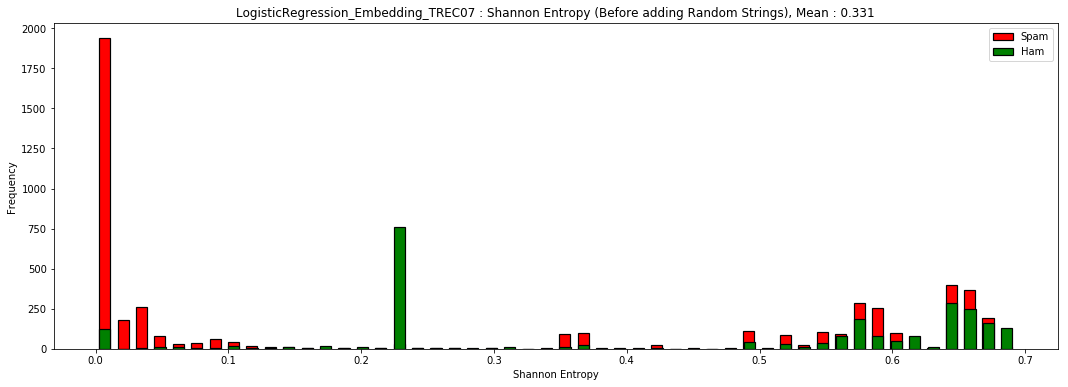

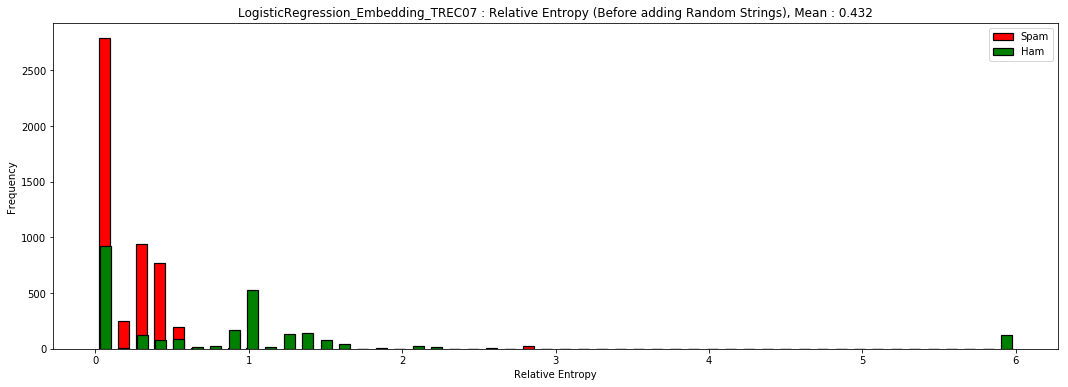

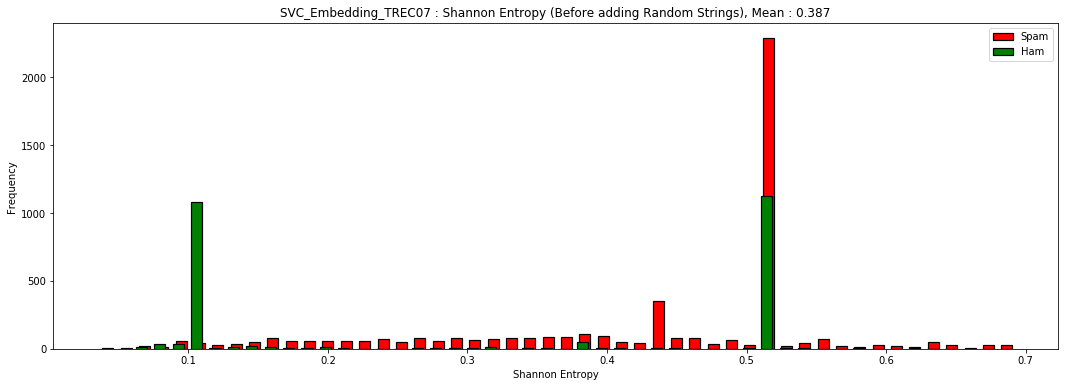

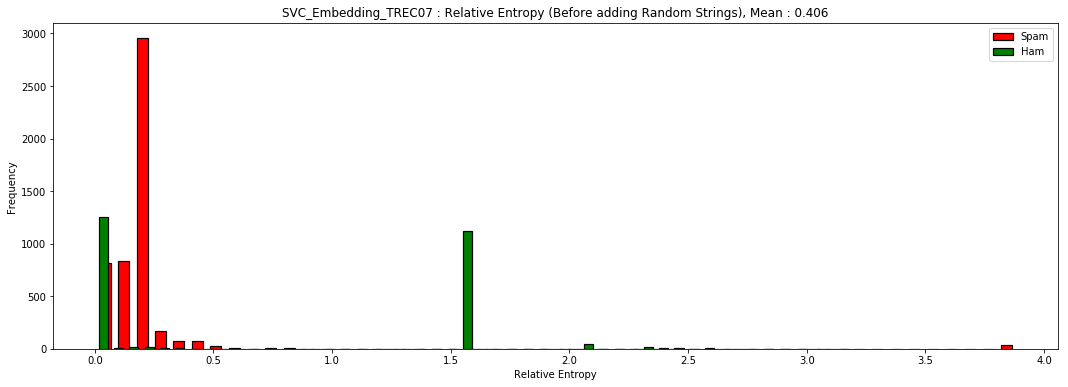

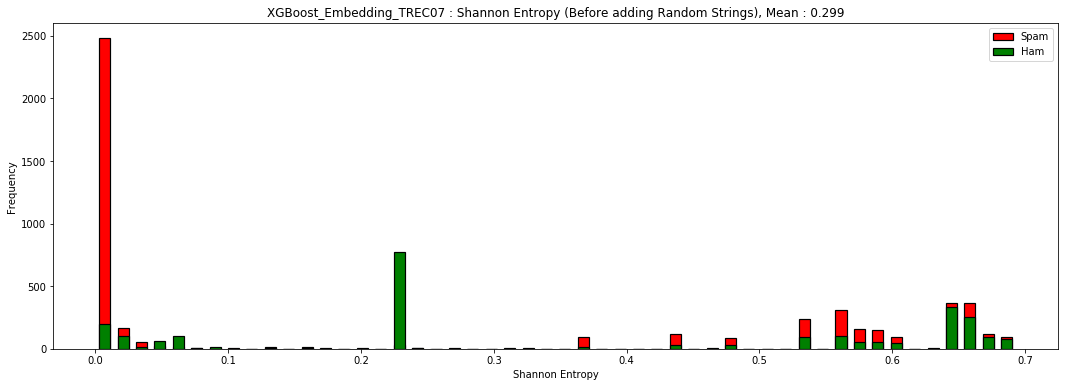

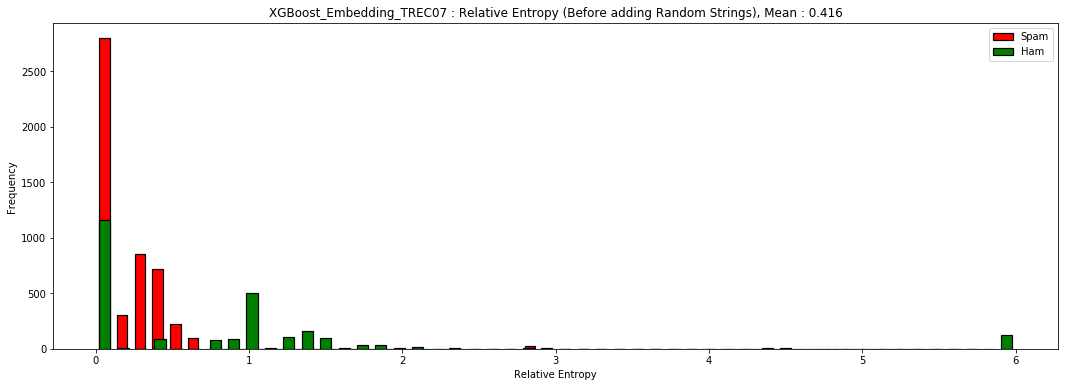

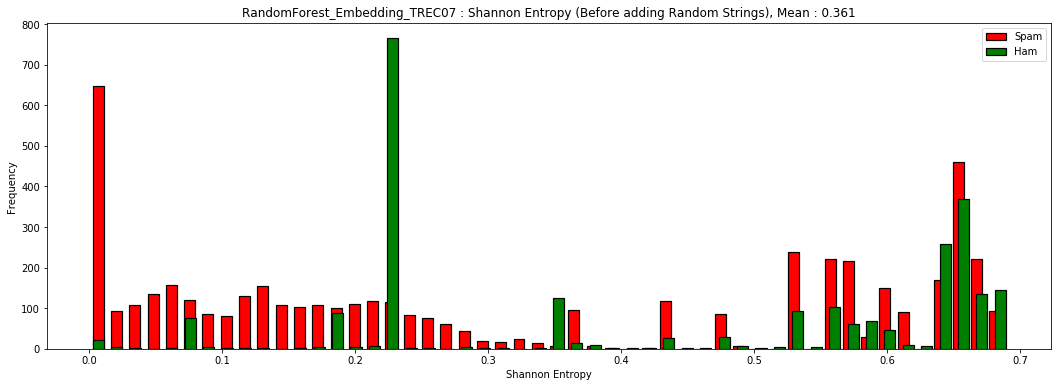

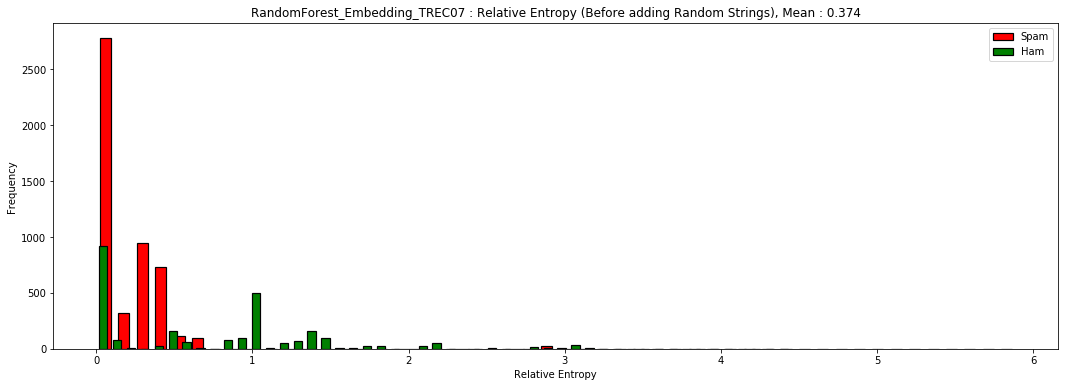

In [36]:
visualise_entropies(dataset, test_x_glove, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
LogisticRegression_Embedding_TREC07
********************************************************************************
Log Loss :  6.264927497494666
ROC AUC :  0.865388327735845
Accuracy :  0.8186157517899761
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.49      0.64      2522
         1.0       0.79      0.99      0.88      5020

   micro avg       0.82      0.82      0.82      7542
   macro avg       0.87      0.74      0.76      7542
weighted avg       0.84      0.82      0.80      7542



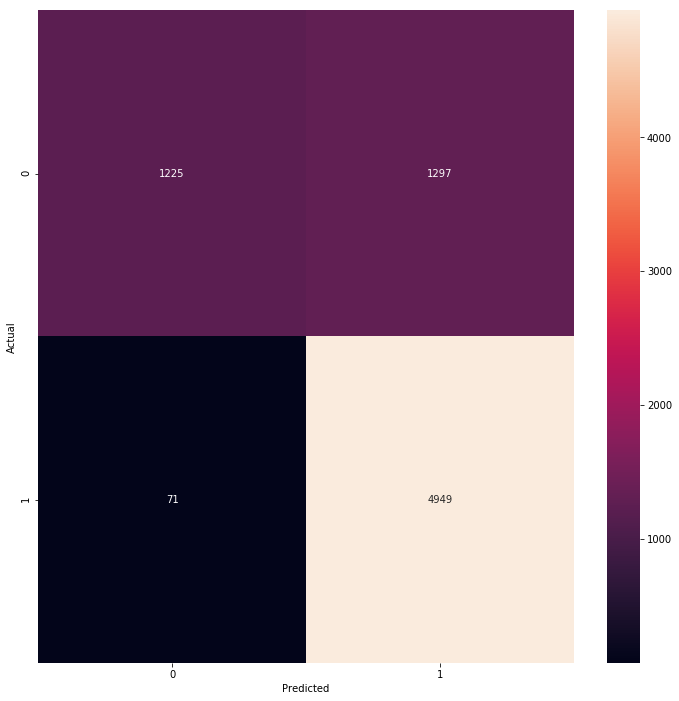

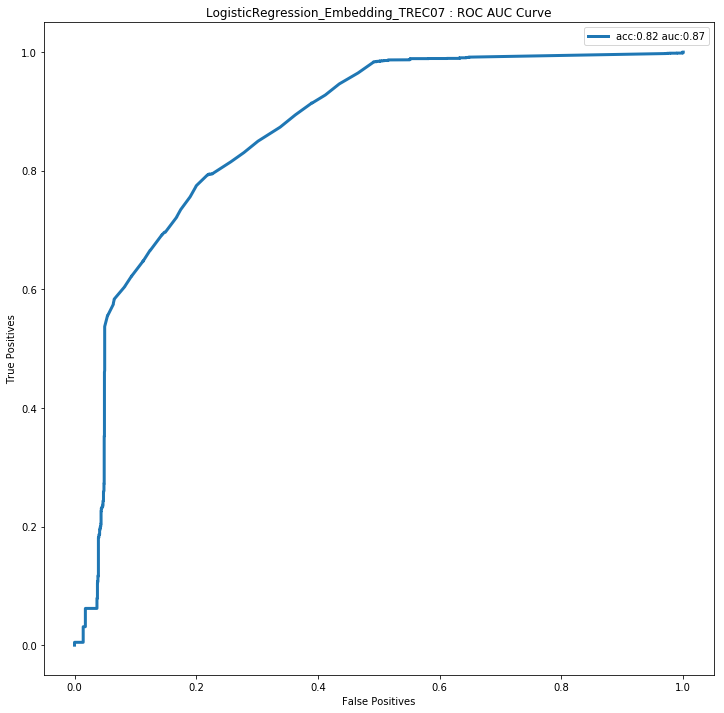

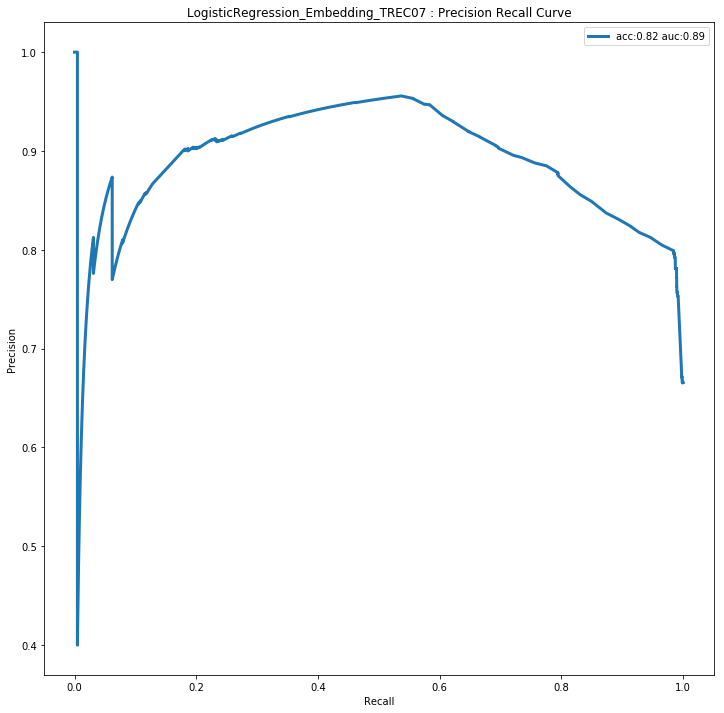

********************************************************************************
SVC_Embedding_TREC07
********************************************************************************
Log Loss :  5.779490654417793
ROC AUC :  0.8291437738340847
Accuracy :  0.8326703792097587
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.51      0.67      2522
         1.0       0.80      0.99      0.89      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.75      0.78      7542
weighted avg       0.86      0.83      0.82      7542



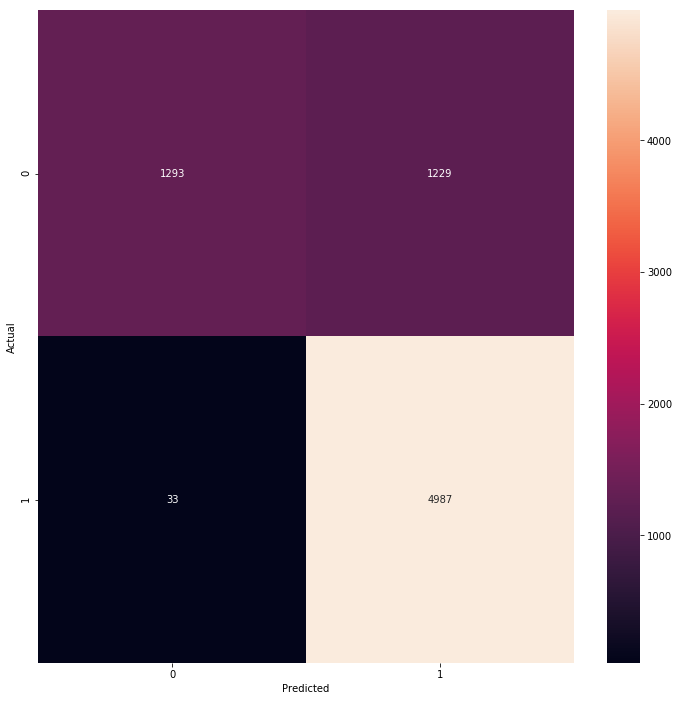

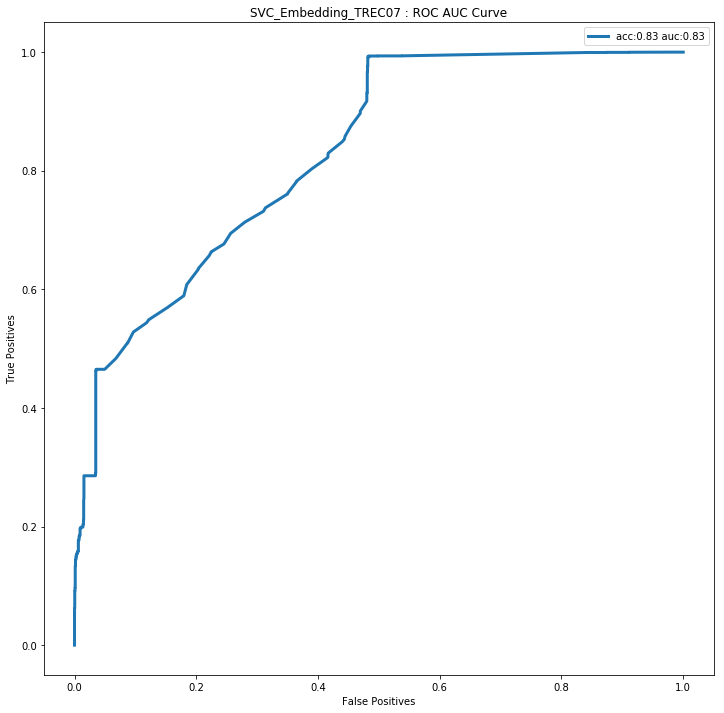

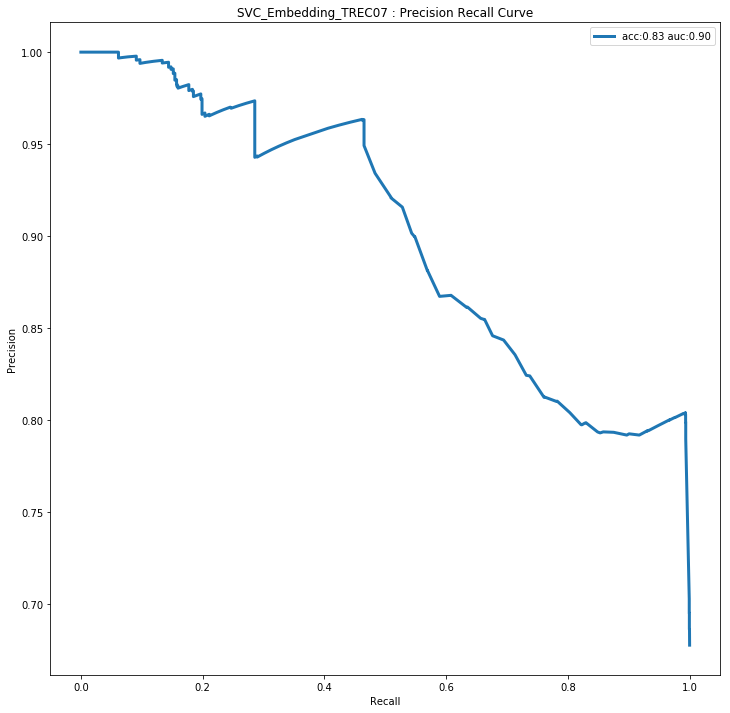

********************************************************************************
XGBoost_Embedding_TREC07
********************************************************************************
Log Loss :  5.962675995082215
ROC AUC :  0.8765829623614977
Accuracy :  0.8273667462211615
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66      2522
         1.0       0.80      0.99      0.88      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.75      0.77      7542
weighted avg       0.86      0.83      0.81      7542



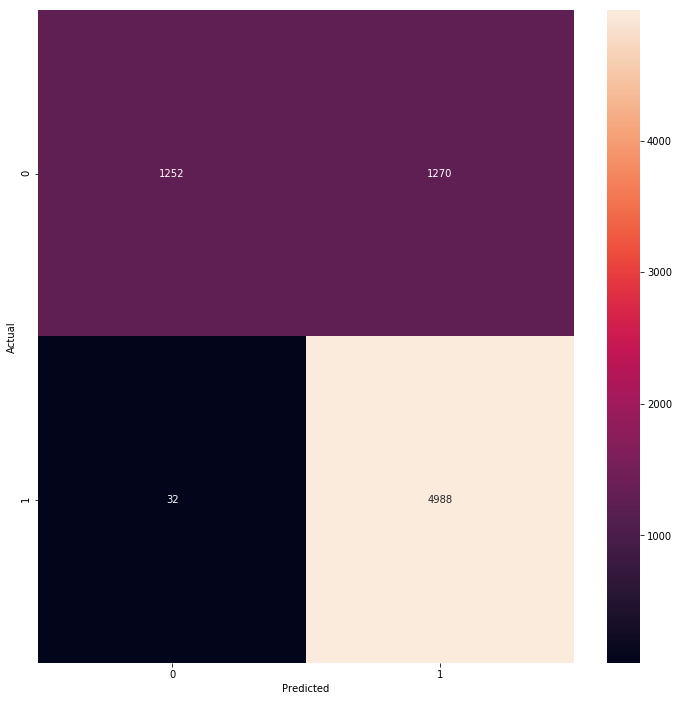

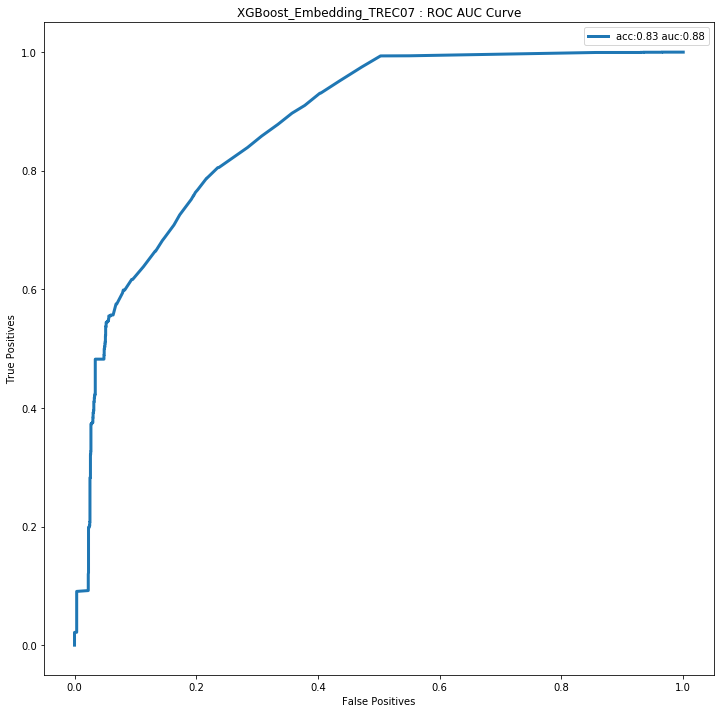

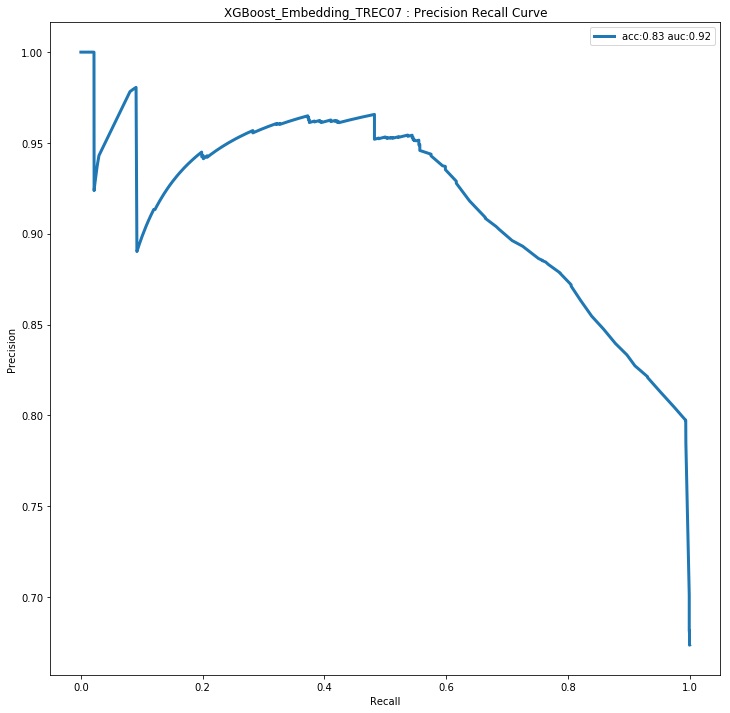

********************************************************************************
RandomForest_Embedding_TREC07
********************************************************************************
Log Loss :  5.9764148876806
ROC AUC :  0.8883322380580769
Accuracy :  0.8269689737470167
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66      2522
         1.0       0.80      0.99      0.88      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.74      0.77      7542
weighted avg       0.86      0.83      0.81      7542



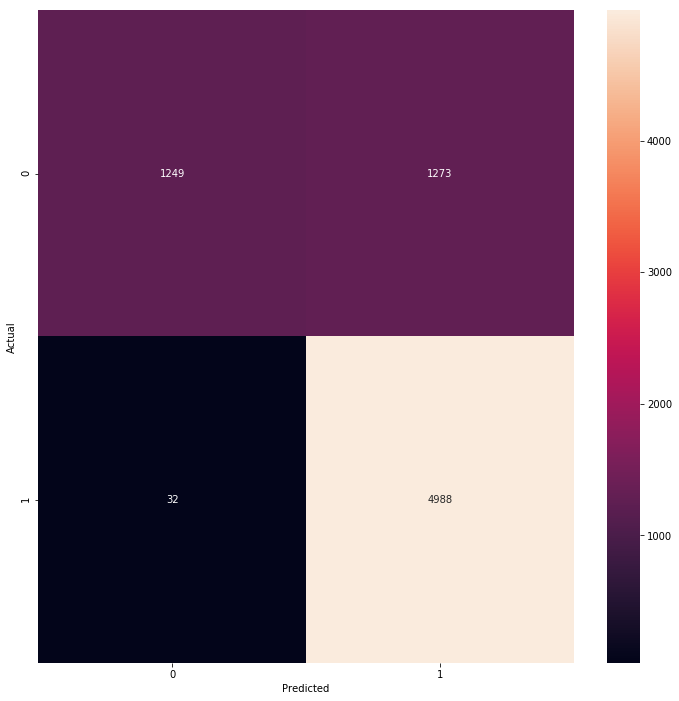

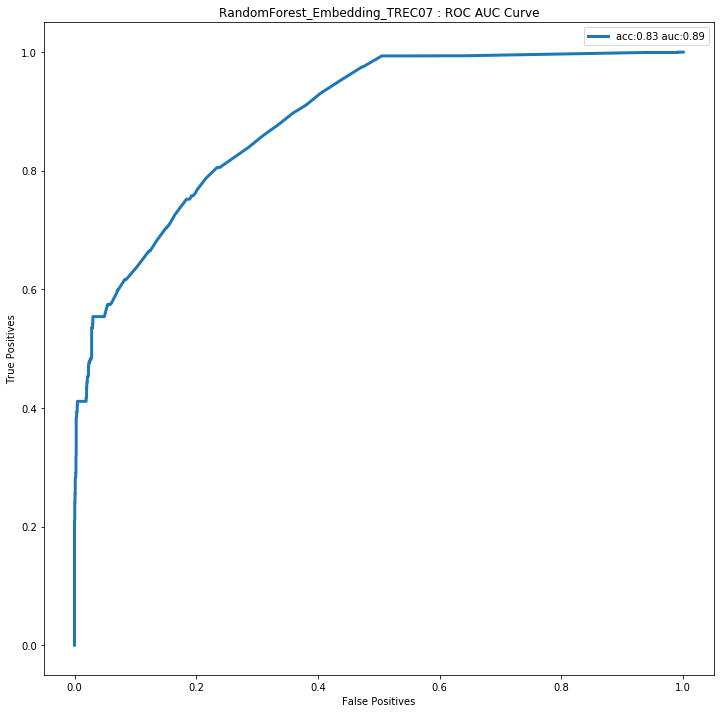

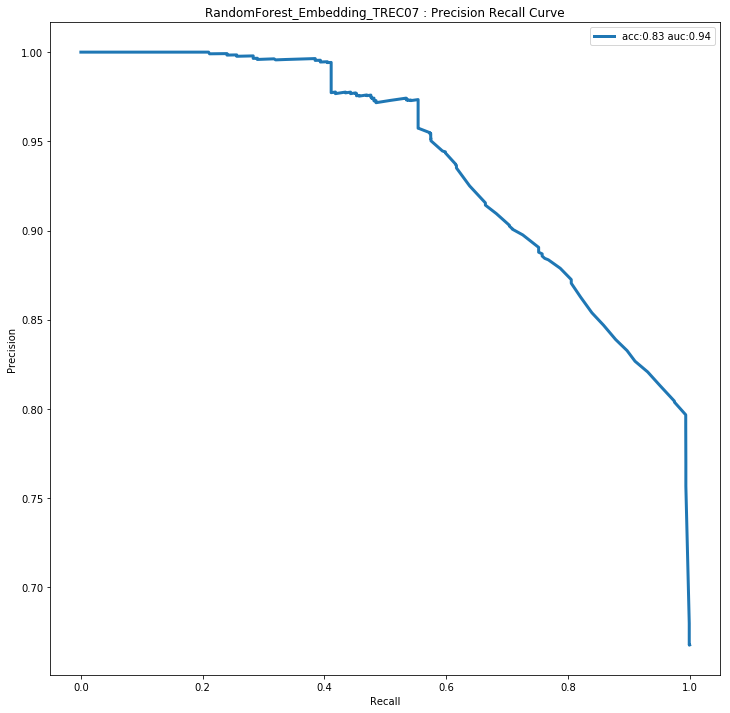

In [37]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_glove, y_test)

## Adding Meaningful Strings to Test Data

In [38]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
test_x_with_random_strings_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_TREC07
********************************************************************************
Mean Shannon Entropy :  0.3309008500400852
Mean Relative Entropy :  0.43183221369932706
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
90     0.682     0.851     1.0     0.0       0.573       0.427
416    0.233     2.776     1.0     0.0       0.938       0.062
425    0.233     2.776     1.0     0.0       0.938       0.062
436    0.233     2.776     1.0     0.0       0.938       0.062
518    0.633     1.114     1.0     0.0       0.672       0.328
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7527    0.643     1.068     0.0     1.0       0.344       0.656
7529    0.656     1.009     0.0     1.0       0.365       0.635
7534    0.663     0.972     0.0     1.0       0.378       0.622
7538    0.642     1.076     0.0     1.0       0.341       0.

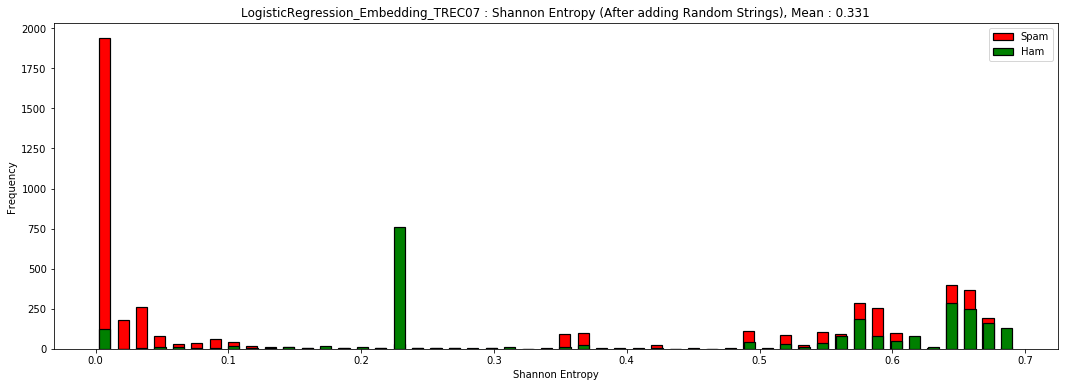

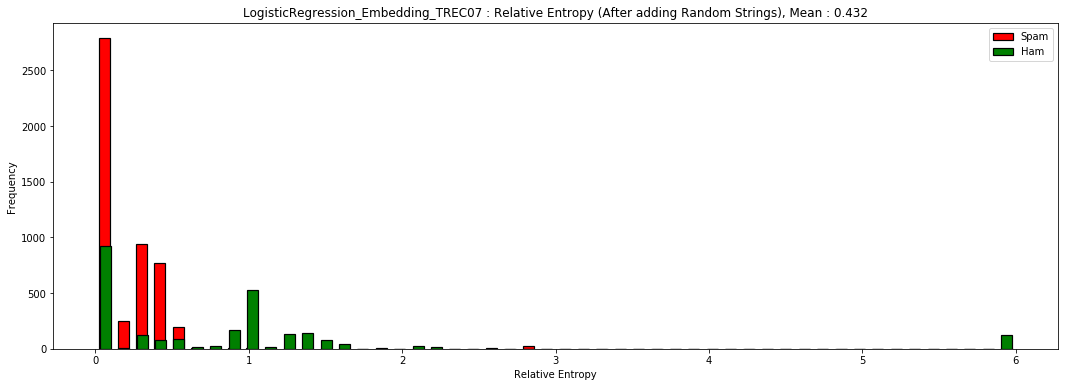

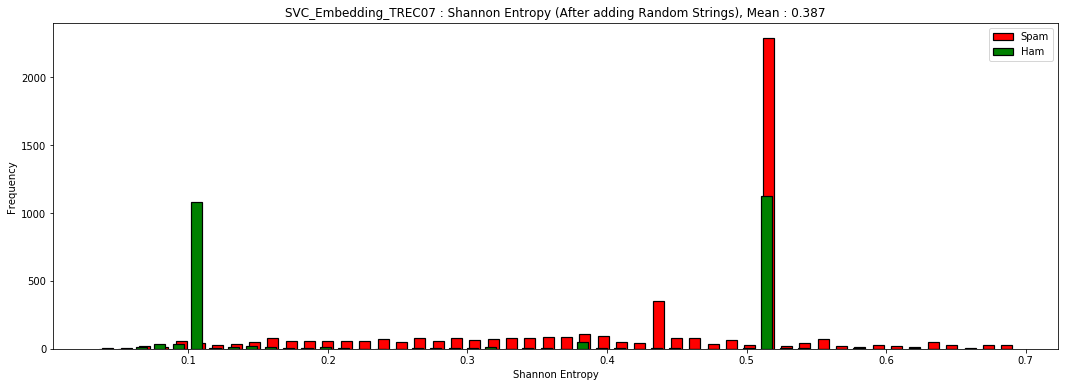

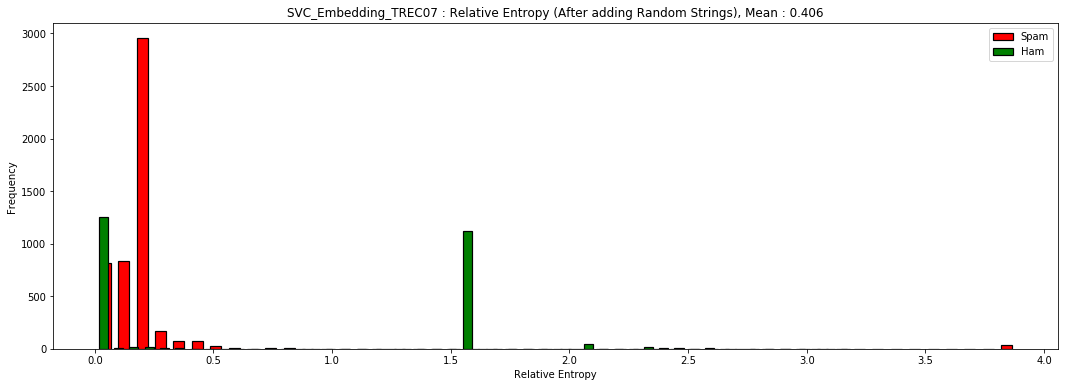

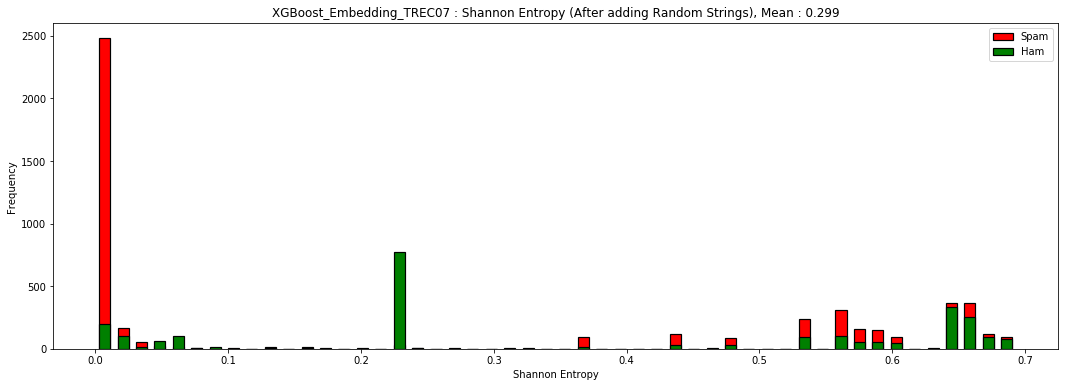

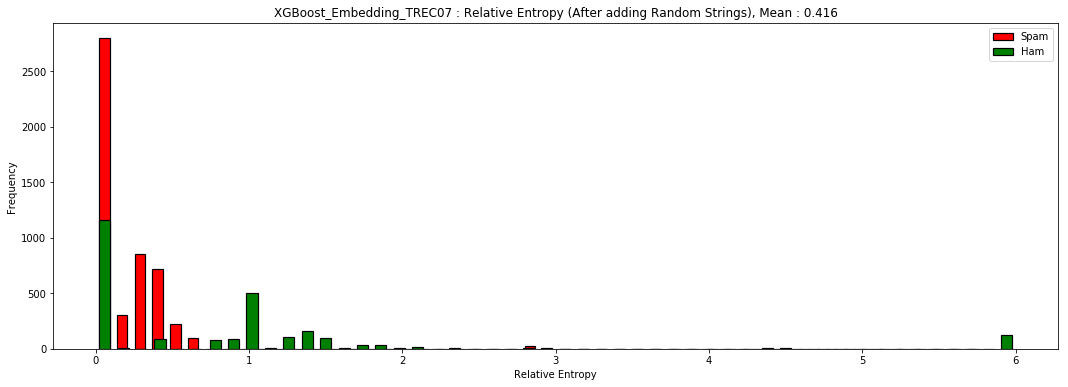

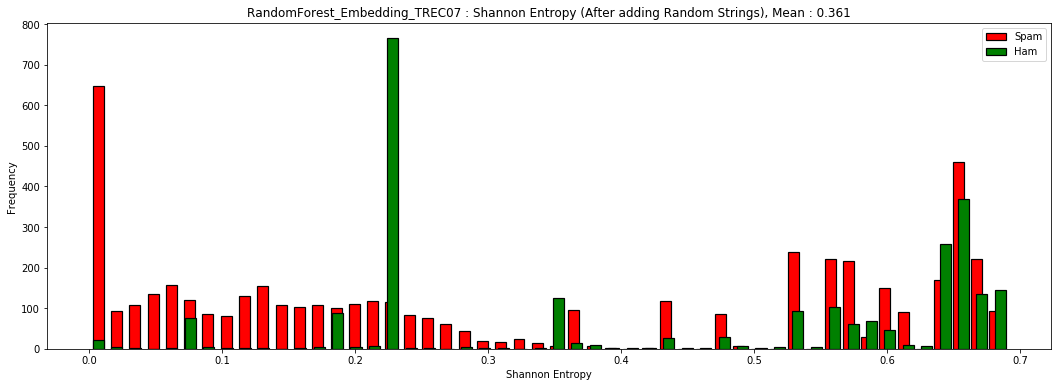

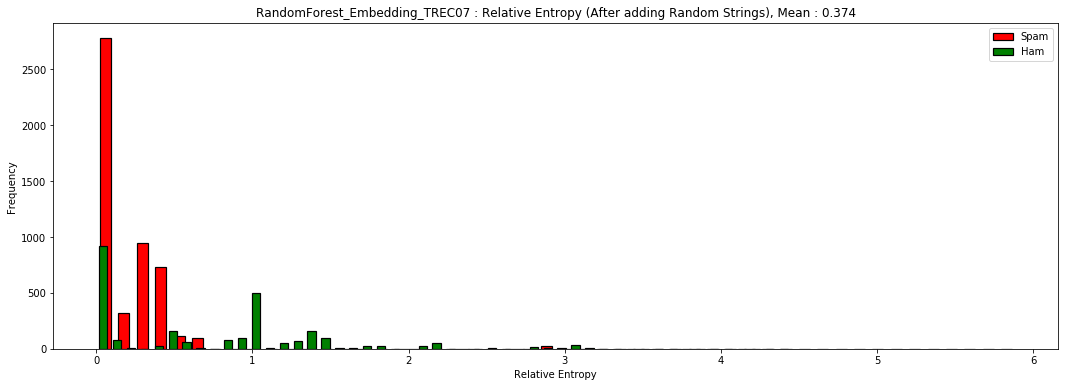

In [39]:
visualise_entropies(dataset, test_x_with_random_strings_glove, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_TREC07
********************************************************************************
Log Loss :  6.264927497494666
ROC AUC :  0.865388327735845
Accuracy :  0.8186157517899761
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.49      0.64      2522
         1.0       0.79      0.99      0.88      5020

   micro avg       0.82      0.82      0.82      7542
   macro avg       0.87      0.74      0.76      7542
weighted avg       0.84      0.82      0.80      7542



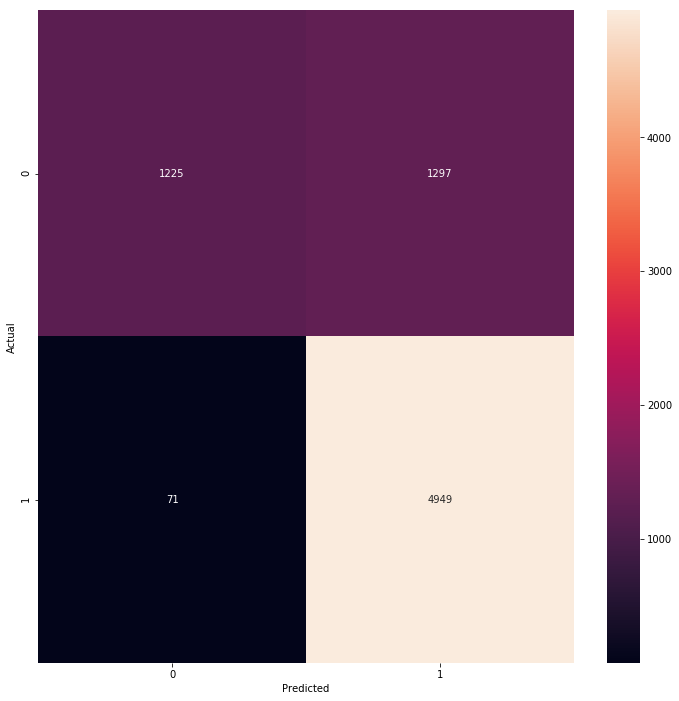

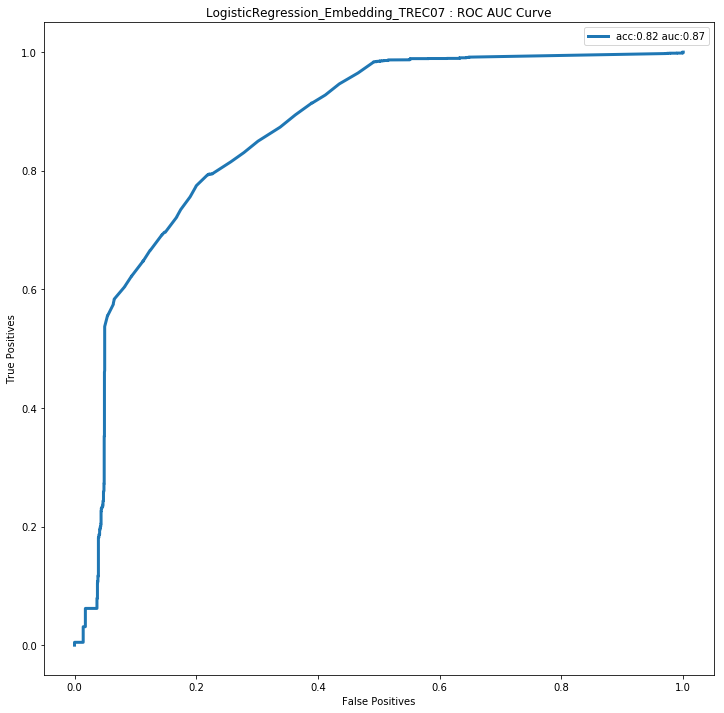

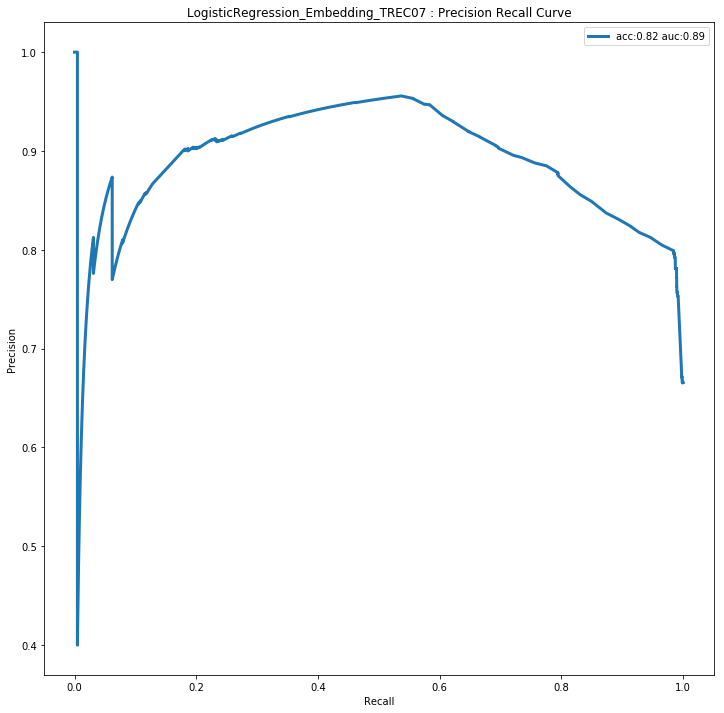

********************************************************************************
SVC_Embedding_TREC07
********************************************************************************
Log Loss :  5.779490654417793
ROC AUC :  0.8291437738340847
Accuracy :  0.8326703792097587
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.51      0.67      2522
         1.0       0.80      0.99      0.89      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.75      0.78      7542
weighted avg       0.86      0.83      0.82      7542



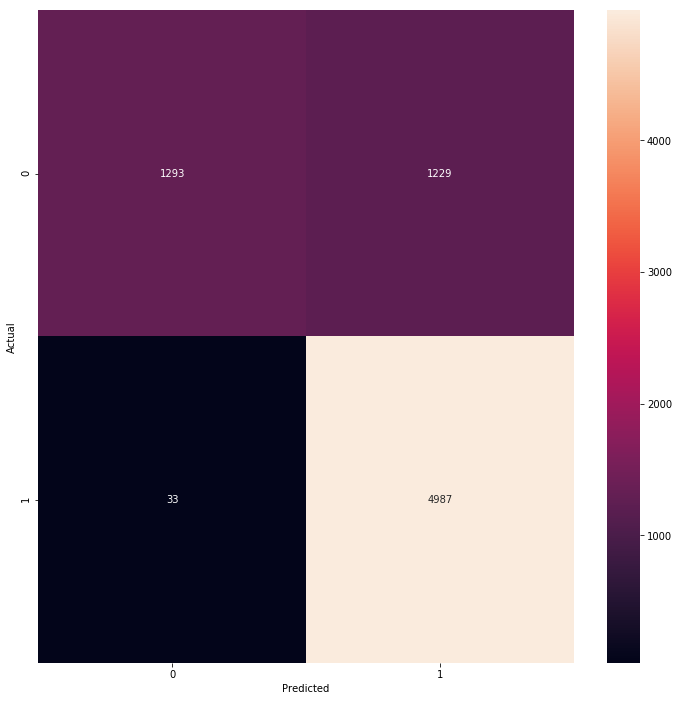

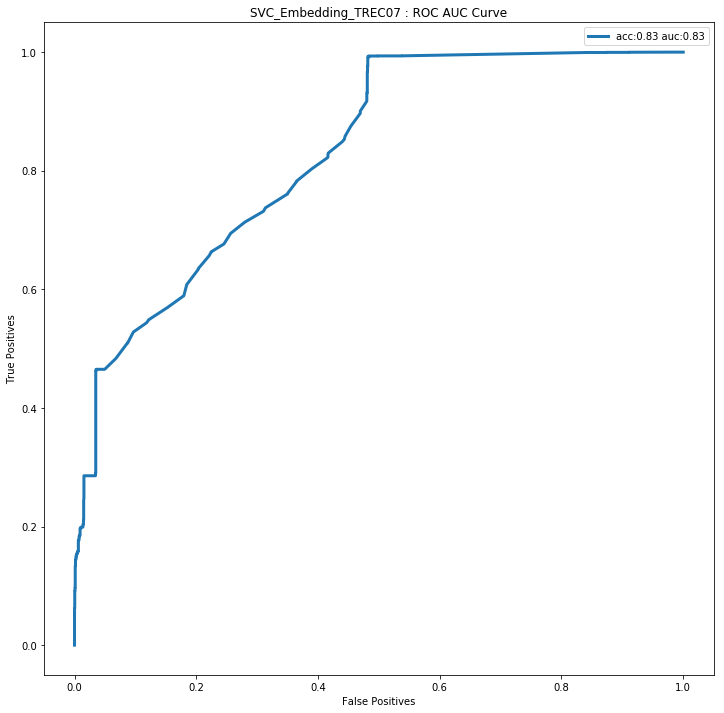

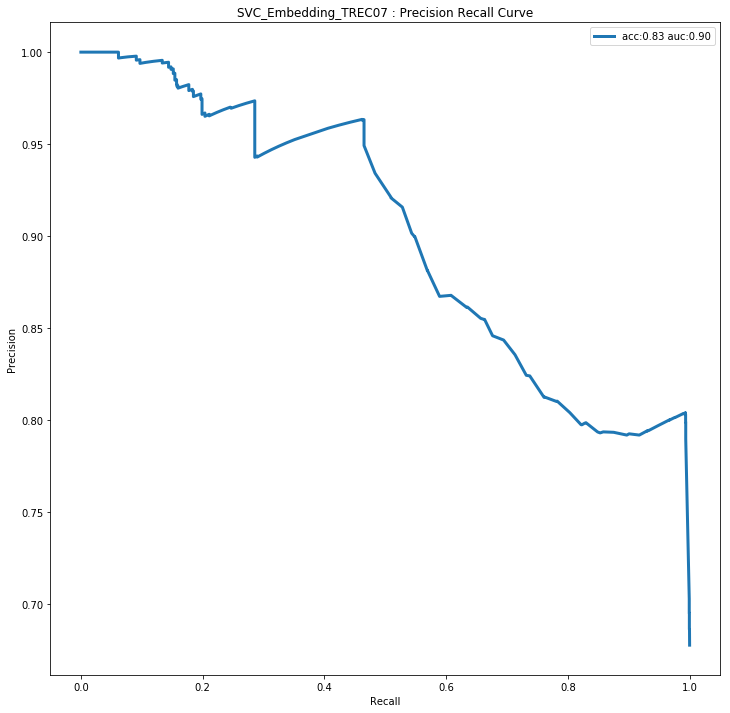

********************************************************************************
XGBoost_Embedding_TREC07
********************************************************************************
Log Loss :  5.962675995082215
ROC AUC :  0.8765829623614977
Accuracy :  0.8273667462211615
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66      2522
         1.0       0.80      0.99      0.88      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.75      0.77      7542
weighted avg       0.86      0.83      0.81      7542



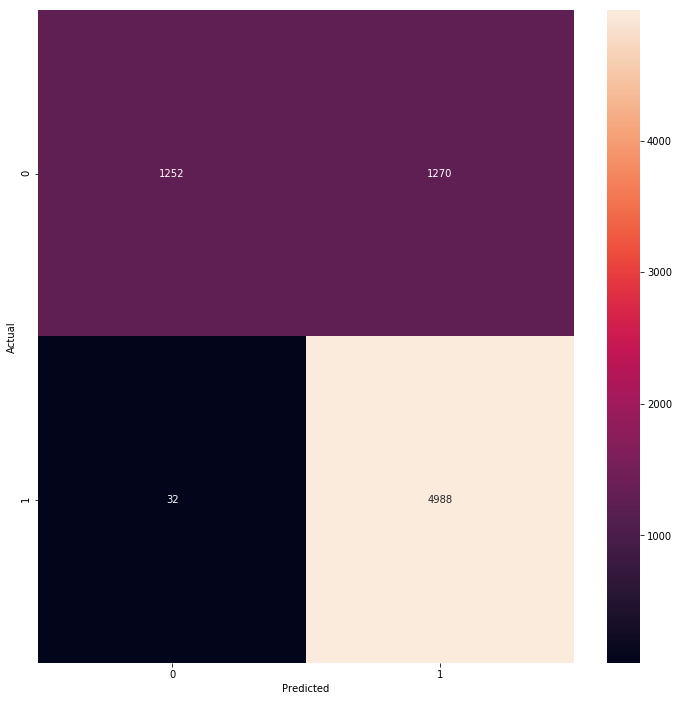

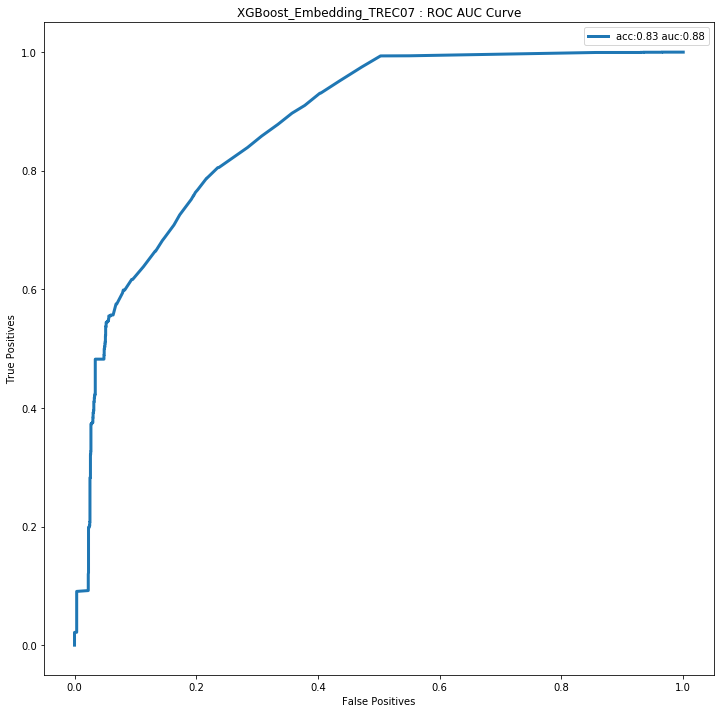

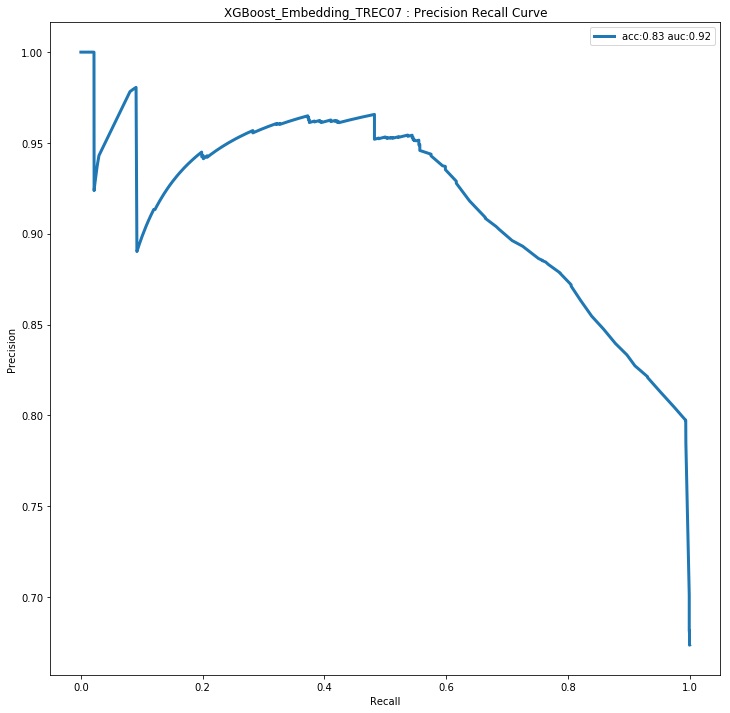

********************************************************************************
RandomForest_Embedding_TREC07
********************************************************************************
Log Loss :  5.9764148876806
ROC AUC :  0.8883322380580769
Accuracy :  0.8269689737470167
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66      2522
         1.0       0.80      0.99      0.88      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.74      0.77      7542
weighted avg       0.86      0.83      0.81      7542



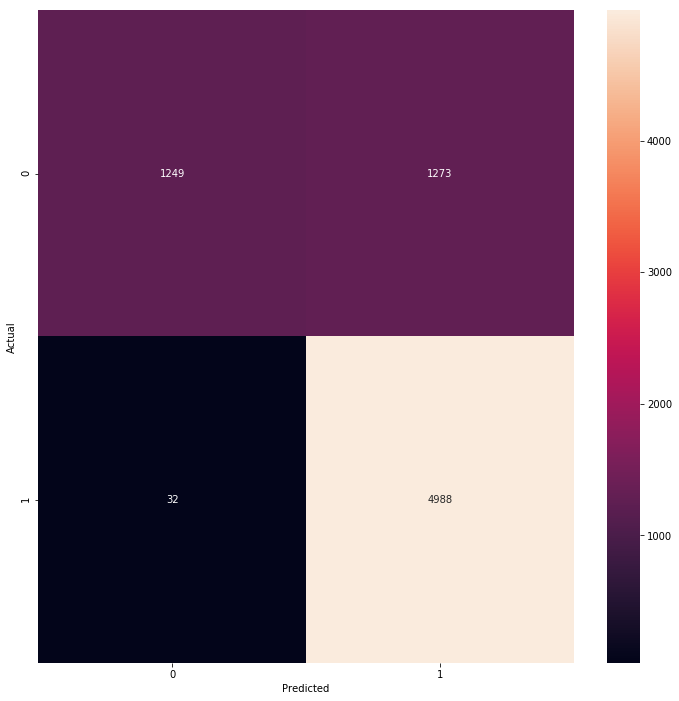

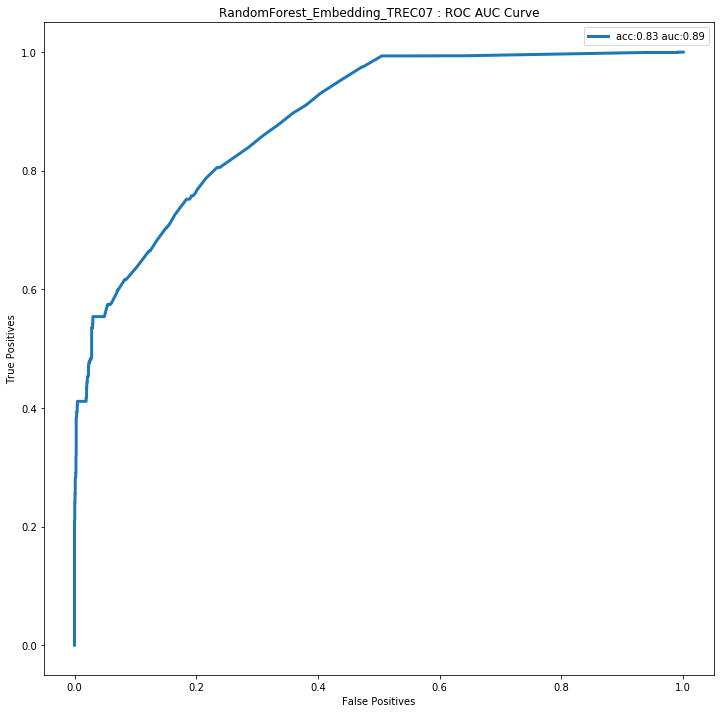

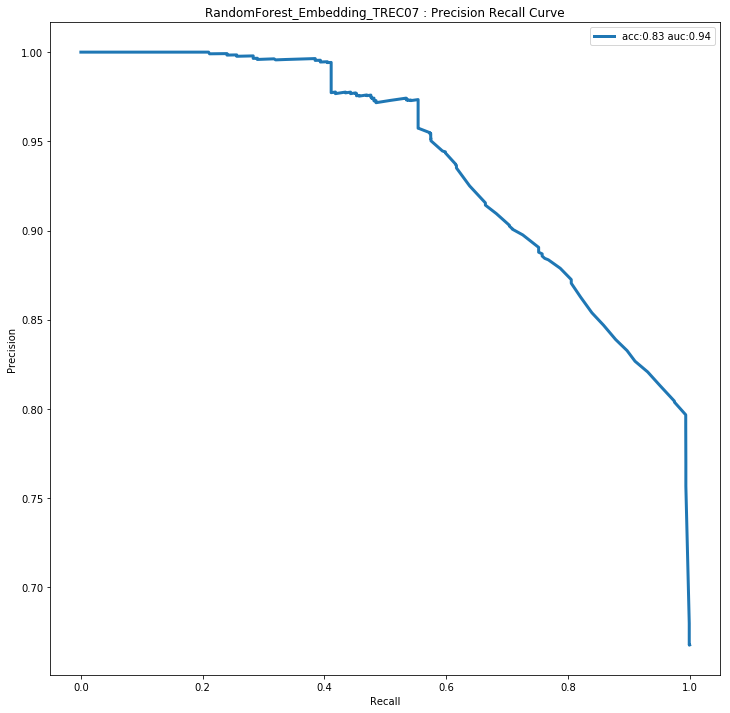

In [40]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_glove, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [41]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
test_x_with_random_strings_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_TREC07
********************************************************************************
Mean Shannon Entropy :  0.3309008500400852
Mean Relative Entropy :  0.43183221369932706
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
90     0.682     0.851     1.0     0.0       0.573       0.427
416    0.233     2.776     1.0     0.0       0.938       0.062
425    0.233     2.776     1.0     0.0       0.938       0.062
436    0.233     2.776     1.0     0.0       0.938       0.062
518    0.633     1.114     1.0     0.0       0.672       0.328
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7527    0.643     1.068     0.0     1.0       0.344       0.656
7529    0.656     1.009     0.0     1.0       0.365       0.635
7534    0.663     0.972     0.0     1.0       0.378       0.622
7538    0.642     1.076     0.0     1.0       0.341       0.

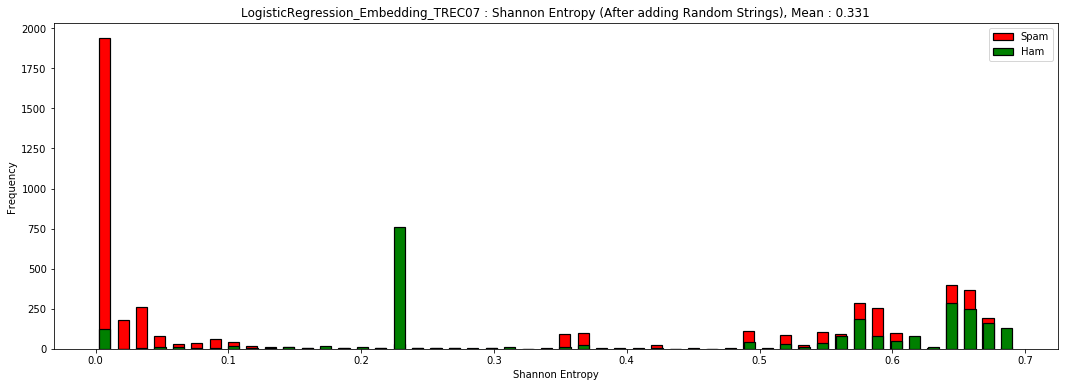

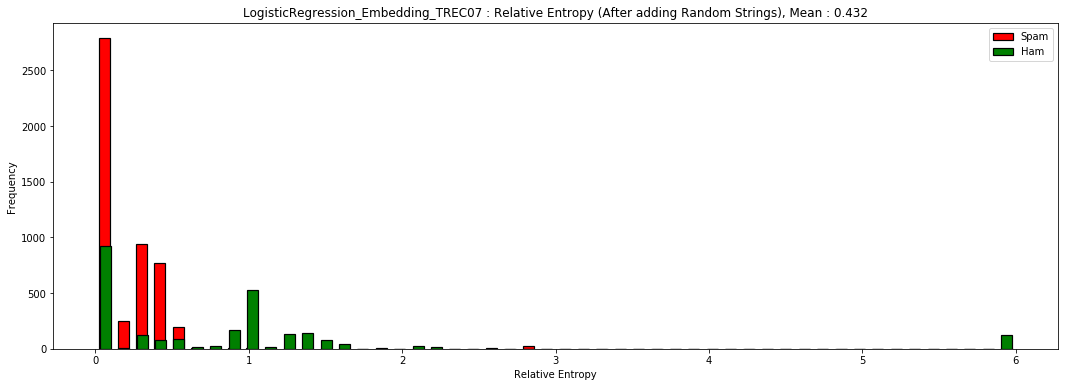

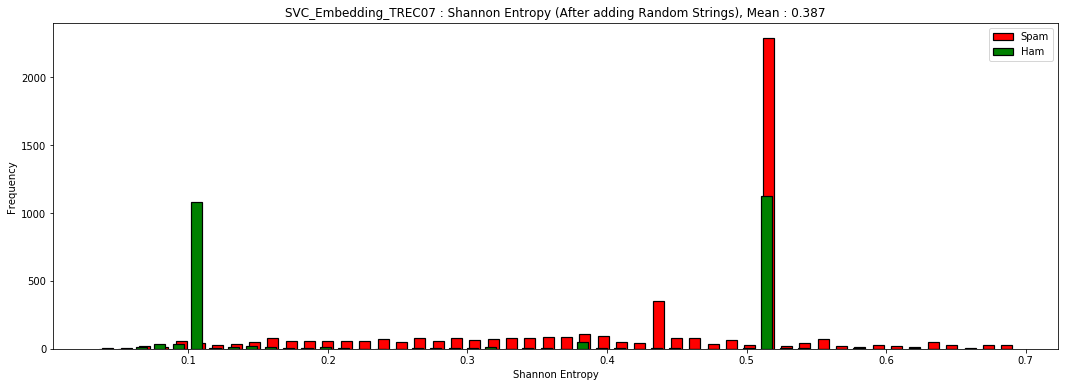

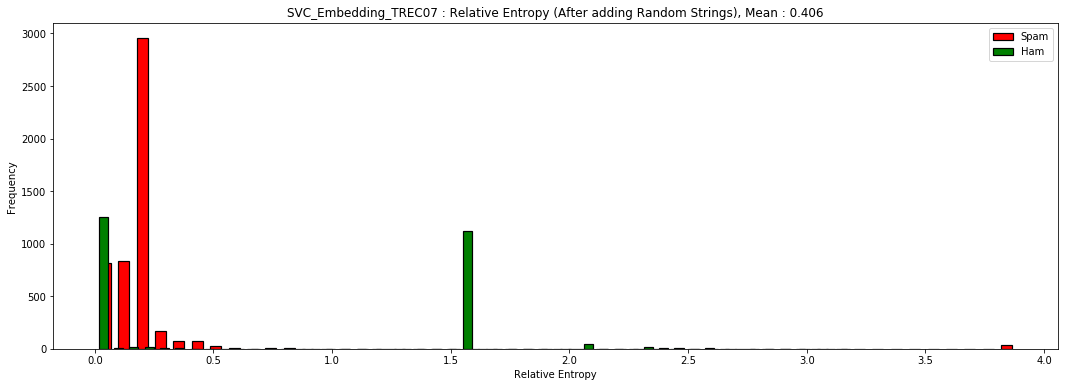

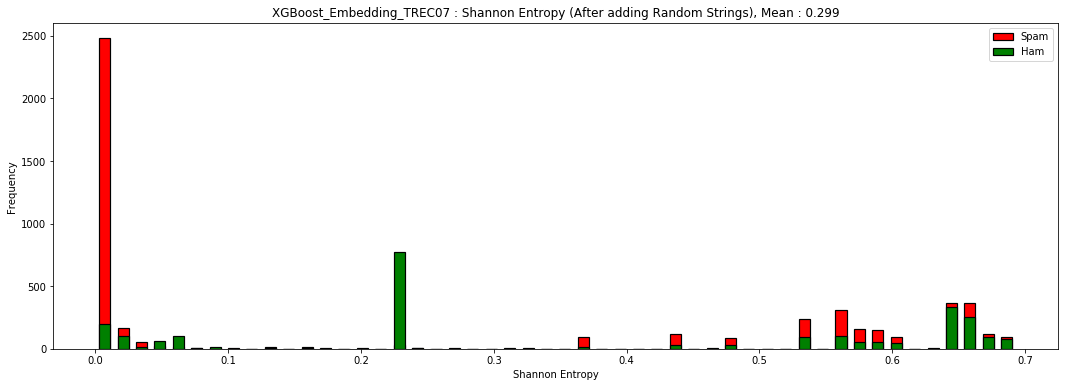

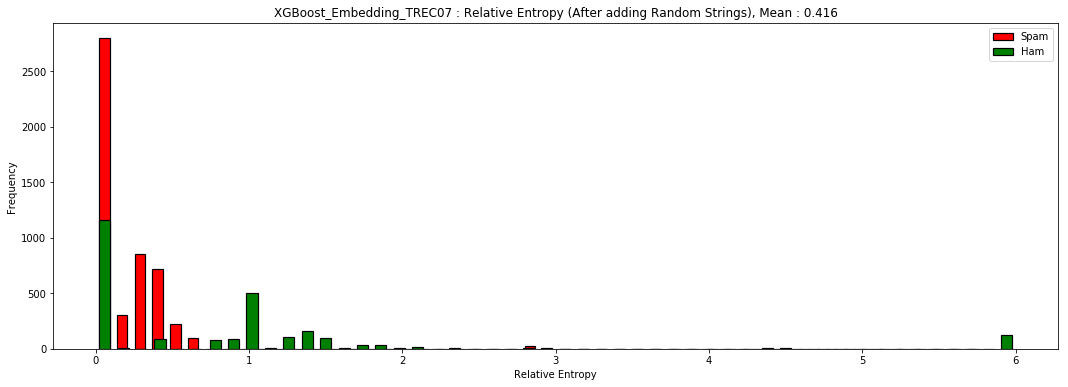

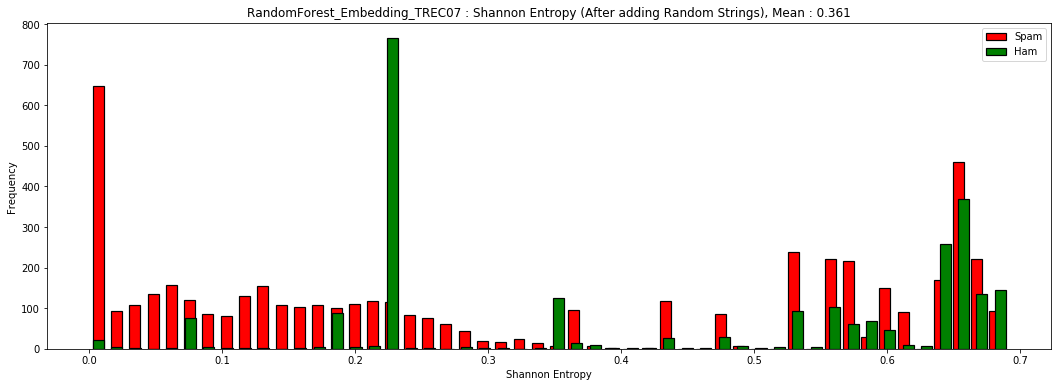

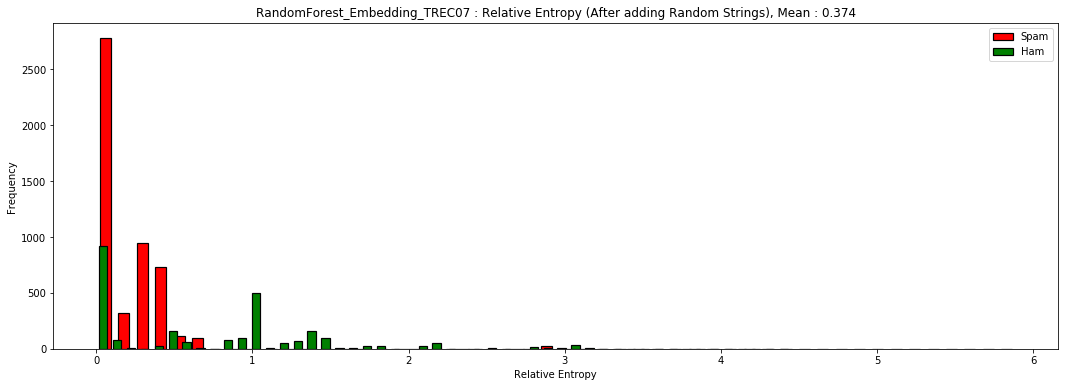

In [42]:
visualise_entropies(dataset, test_x_with_random_strings_glove, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_TREC07
********************************************************************************
Log Loss :  6.264927497494666
ROC AUC :  0.865388327735845
Accuracy :  0.8186157517899761
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.49      0.64      2522
         1.0       0.79      0.99      0.88      5020

   micro avg       0.82      0.82      0.82      7542
   macro avg       0.87      0.74      0.76      7542
weighted avg       0.84      0.82      0.80      7542



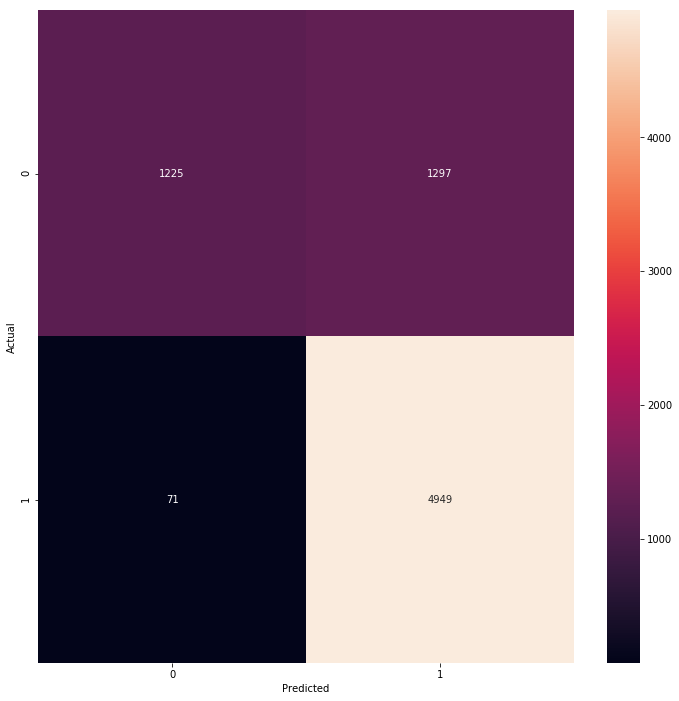

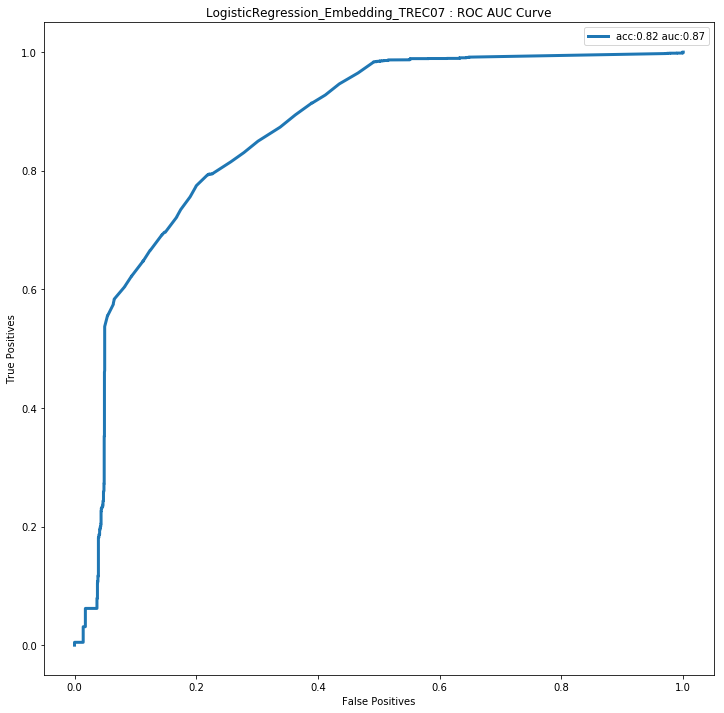

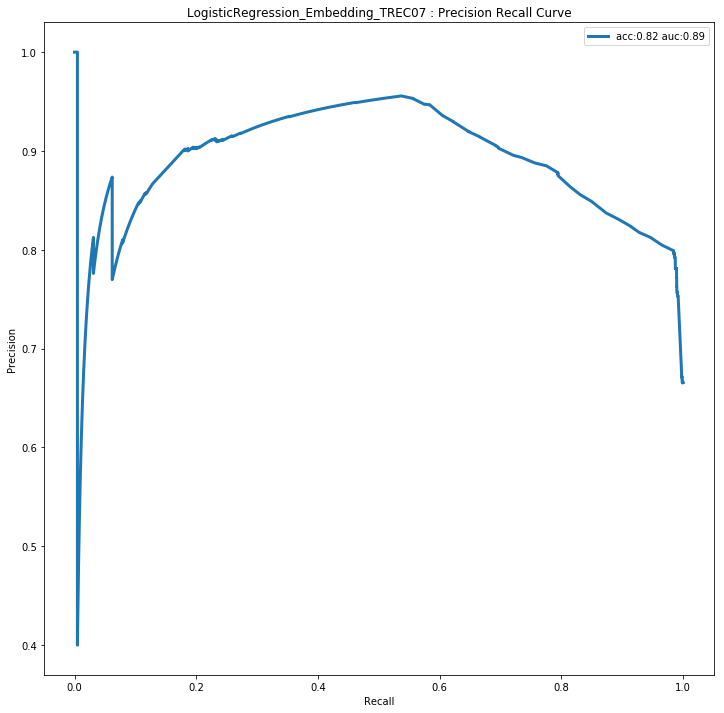

********************************************************************************
SVC_Embedding_TREC07
********************************************************************************
Log Loss :  5.779490654417793
ROC AUC :  0.8291437738340847
Accuracy :  0.8326703792097587
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.51      0.67      2522
         1.0       0.80      0.99      0.89      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.75      0.78      7542
weighted avg       0.86      0.83      0.82      7542



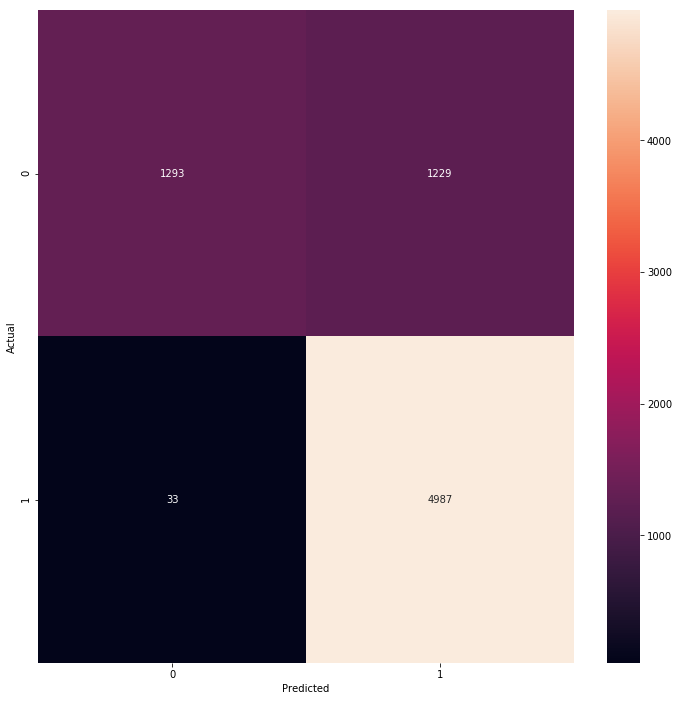

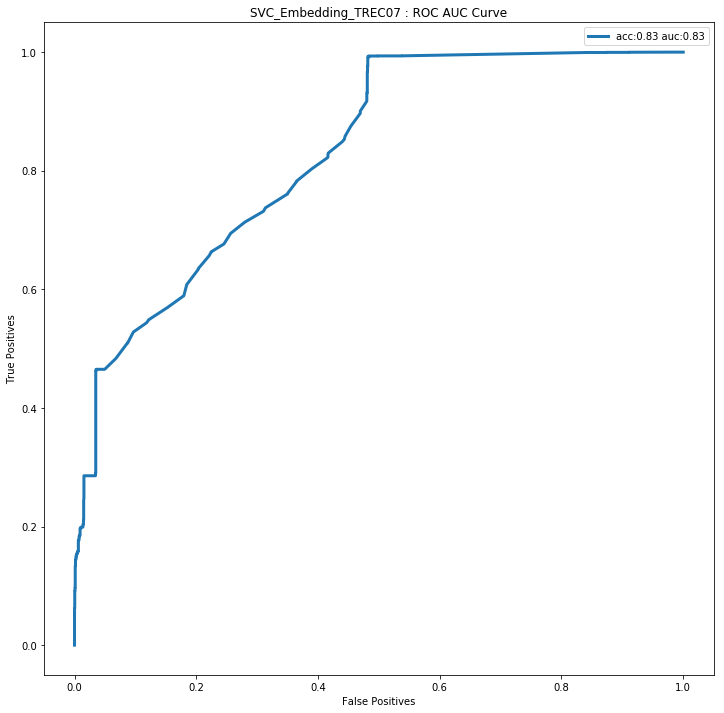

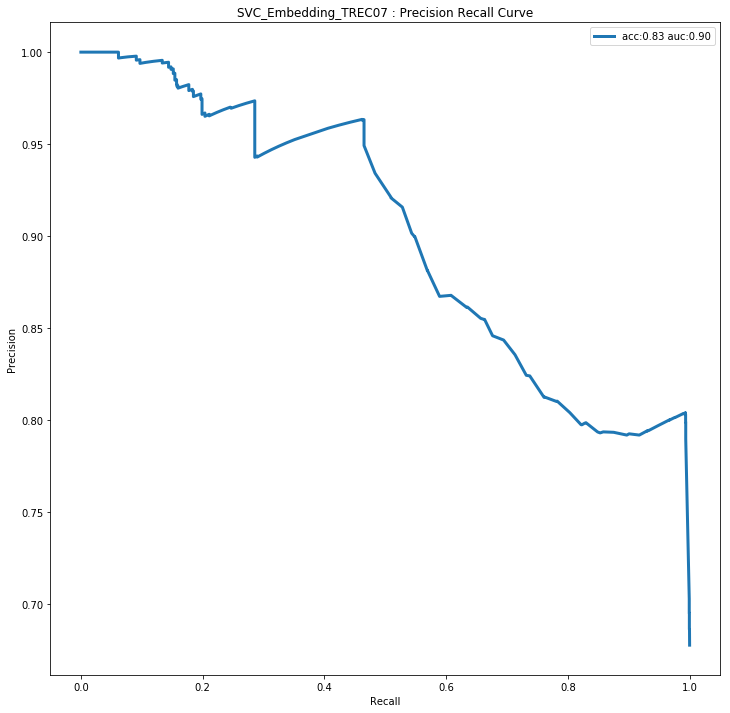

********************************************************************************
XGBoost_Embedding_TREC07
********************************************************************************
Log Loss :  5.962675995082215
ROC AUC :  0.8765829623614977
Accuracy :  0.8273667462211615
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66      2522
         1.0       0.80      0.99      0.88      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.75      0.77      7542
weighted avg       0.86      0.83      0.81      7542



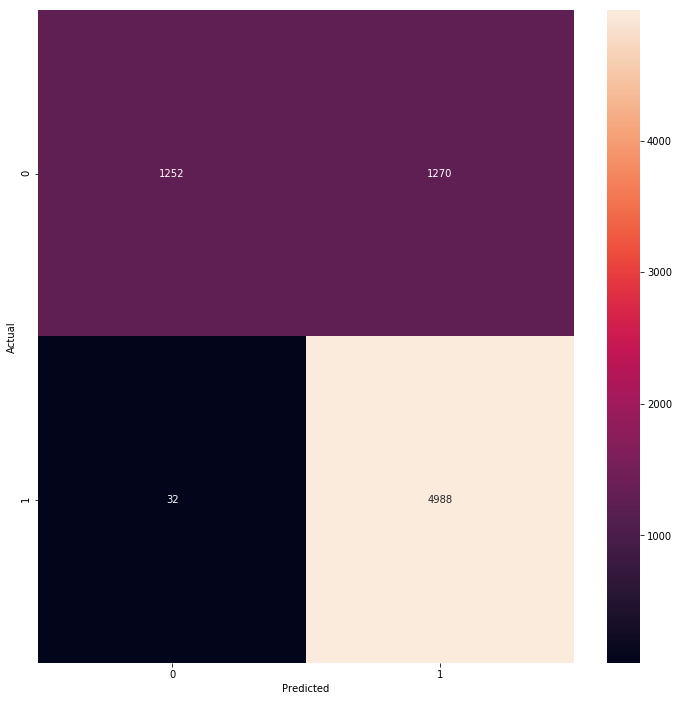

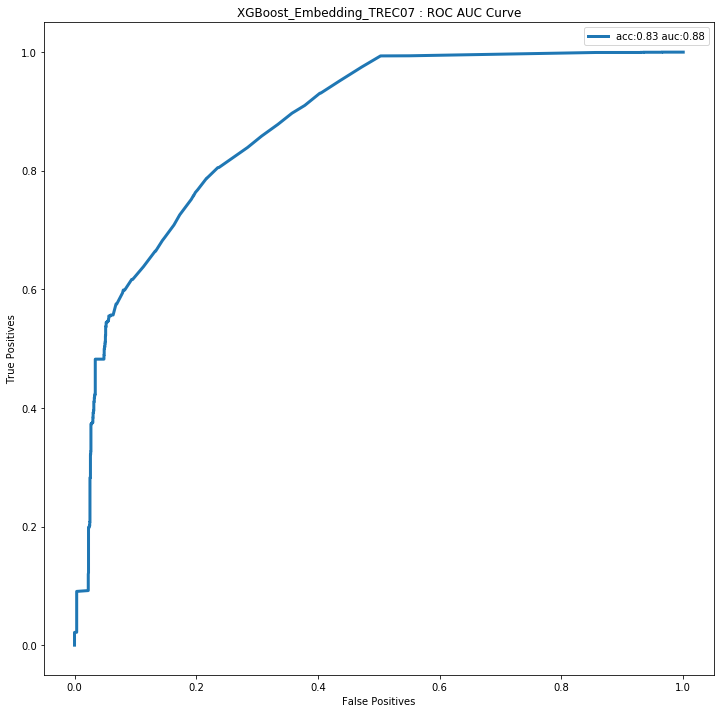

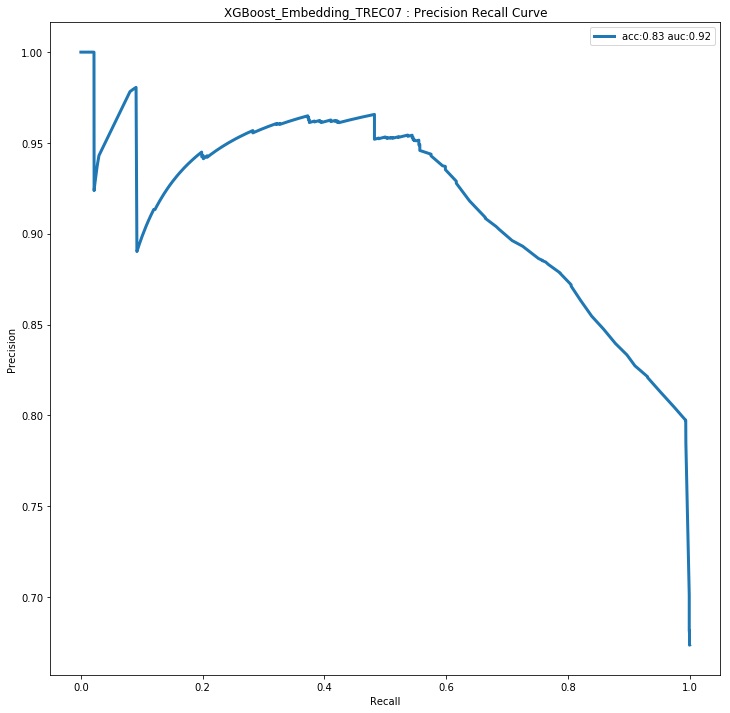

********************************************************************************
RandomForest_Embedding_TREC07
********************************************************************************
Log Loss :  5.9764148876806
ROC AUC :  0.8883322380580769
Accuracy :  0.8269689737470167
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66      2522
         1.0       0.80      0.99      0.88      5020

   micro avg       0.83      0.83      0.83      7542
   macro avg       0.89      0.74      0.77      7542
weighted avg       0.86      0.83      0.81      7542



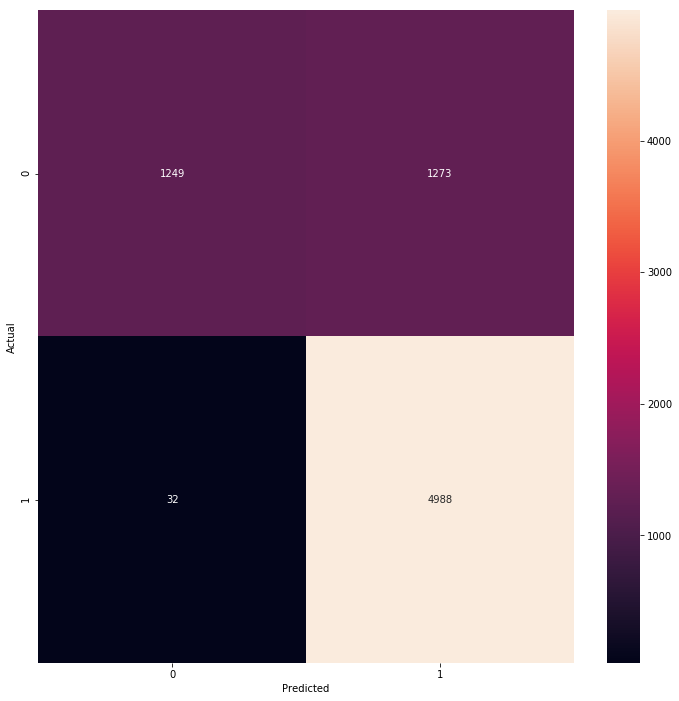

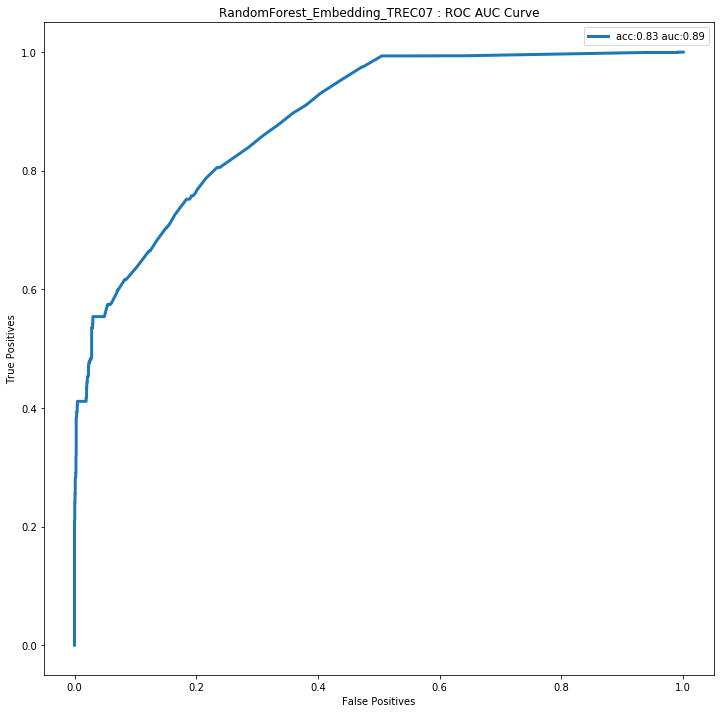

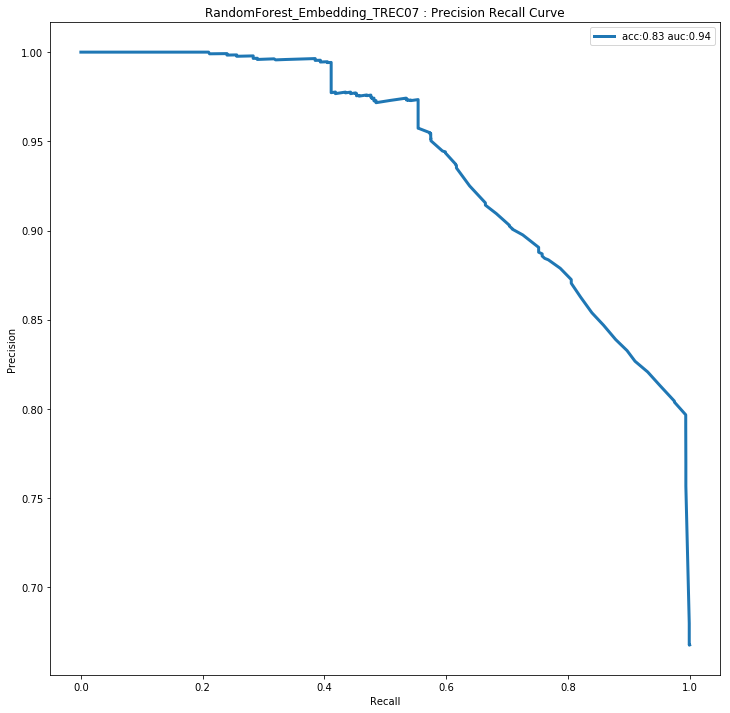

In [43]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_glove, y_test)

## 2. Embeddings with Dense Network

In [44]:
%%time
grids = {}
num_max = 20000
le = LabelEncoder()
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(train_x_cleaned)
train_x_dense = tok.texts_to_matrix(train_x_cleaned,mode='count')
test_x_dense = tok.texts_to_matrix(test_x_cleaned,mode='count')
print(y_train.shape,train_x_dense.shape, y_test.shape, test_x_dense.shape)

(30167,) (30167, 20000) (7542,) (7542, 20000)
CPU times: user 1.57 s, sys: 192 ms, total: 1.76 s
Wall time: 1.76 s


In [45]:
dense_model = get_dense_model(num_max)
dense_model.fit(train_x_dense,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['DNN_'+dataset] = copy.deepcopy(dense_model)

gc.enable(); gc.collect();

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
compile done
Instructions for updating:
Use tf.cast instead.
Train on 24133 samples, validate on 6034 samples
Epoch 1/10
24133/24133 [==============================] - 24s 999us/step - loss: 0.0326 - acc: 0.9916 - val_loss: 0.0523 - val_acc: 0.9920
Epoch 2/10
24133/24133 [==============================] - 15s 626us/step - loss: 0.0084 - acc: 0.9986 - val_loss: 0.0653 - val_acc: 0.9901
Epoch 3/10
24133/24133 [==============================] - 15s 626us/step - loss: 0.0065 - acc: 0.9989 - val_loss: 0.0575 - val_acc: 0.9957
Epoch 4/10
24133/24133 [==============================] - 15s 626us/step - loss: 0.0093 - acc: 0.9983 - val_loss: 0.0490 - val_acc: 0.9960
Epoch 5/10
24133/24133 [==============================] - 15s 627us/step - loss: 0.0058 - acc: 0.9991 - val_loss: 0.0476 - val_acc: 0.9970
Epoch 6/

## Visualise Shannon and Relative entropies for various models

********************************************************************************
DNN_TREC07
********************************************************************************
Mean Shannon Entropy :  5.449654e-06
Mean Relative Entropy :  0.03494062259478387
Head 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
596     0.000     6.000     1.0       0       1.000       0.000
1261    0.000     6.000     1.0       0       1.000       0.000
3117    0.026     5.522     1.0       0       0.996       0.004
5051    0.000     6.000     0.0       1       0.000       1.000
5059    0.000     6.000     0.0       1       0.000       1.000
Tail 5 : 
        Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7423  0.000e+00       6.0     0.0       1   0.000e+00         1.0
7430  5.299e-04       6.0     0.0       1   4.846e-05         1.0
7467  5.299e-04       6.0     0.0       1   4.846e-05         1.0
7485  5.299e-04       6.0     0.0       1   4.846e-05         1.0
7508  0.000

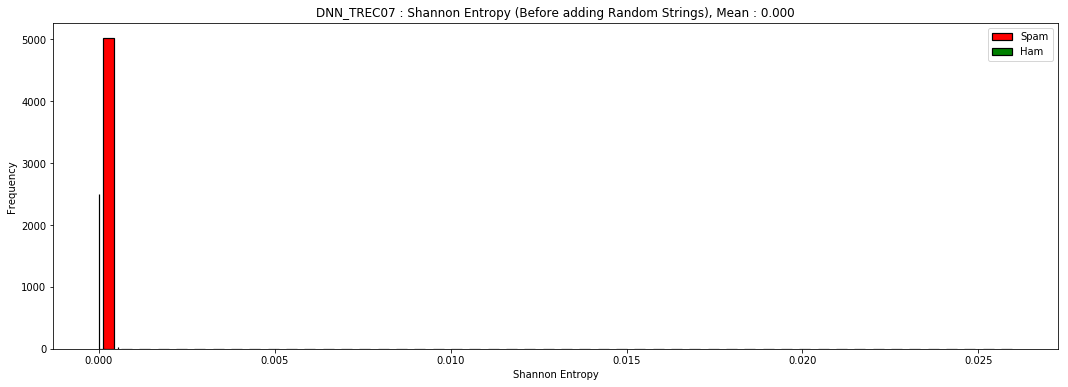

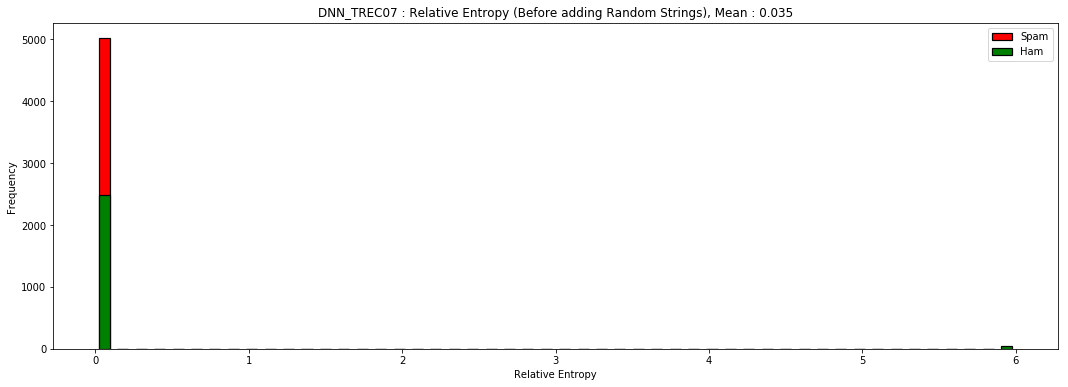

In [46]:
visualise_entropies(dataset, test_x_dense, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
DNN_TREC07
********************************************************************************
Log Loss :  0.20150344005180523
ROC AUC :  0.997019139935105
Accuracy :  0.994166003712543
Classification Report : 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2522
         1.0       0.99      1.00      1.00      5020

   micro avg       0.99      0.99      0.99      7542
   macro avg       1.00      0.99      0.99      7542
weighted avg       0.99      0.99      0.99      7542



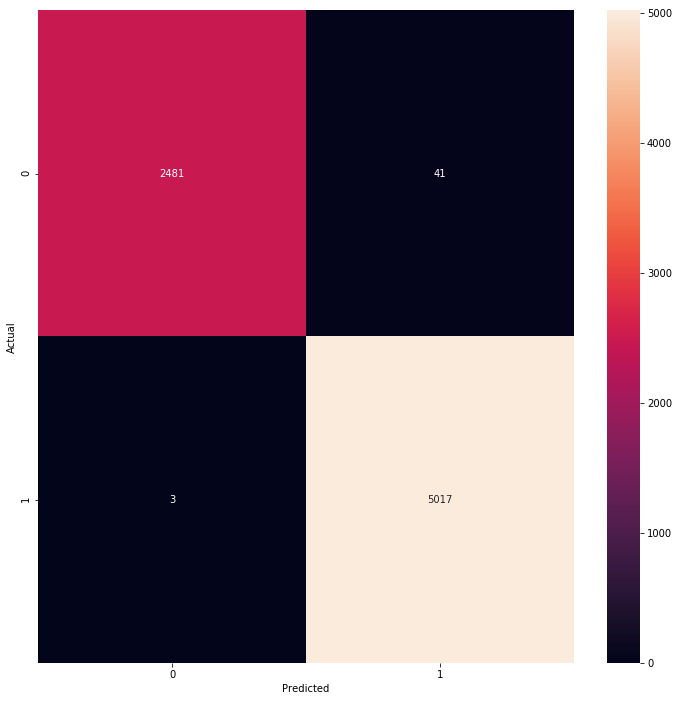

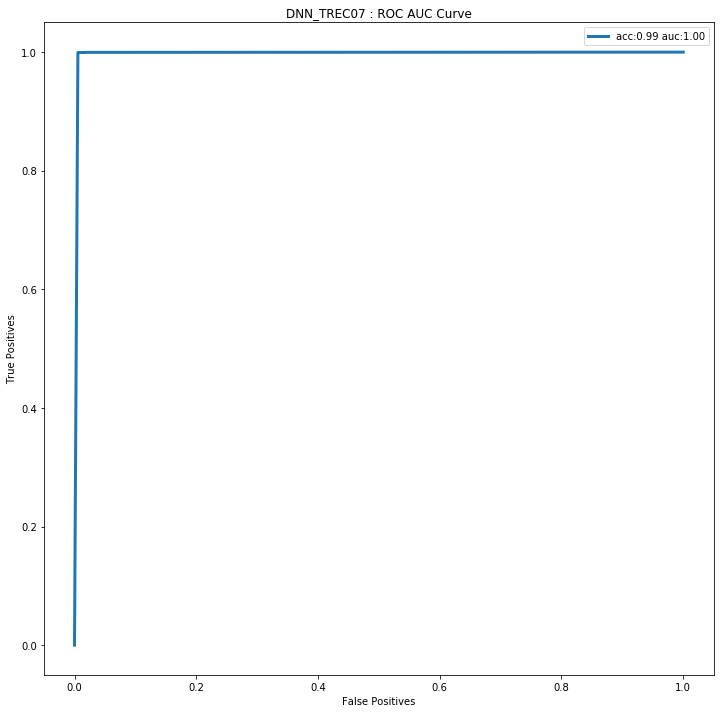

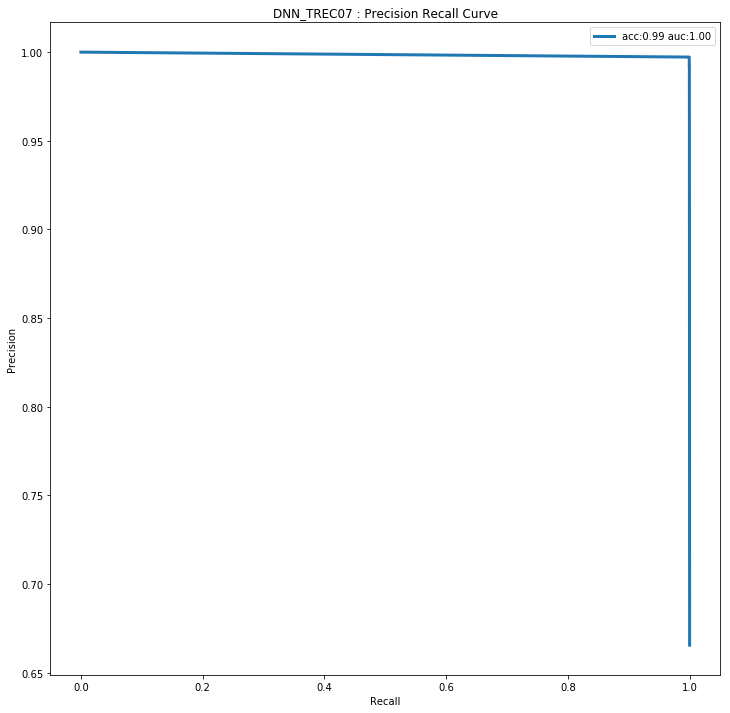

In [47]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_dense, y_test)

## Adding Meaningful Strings to Test Data

In [48]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
test_x_with_random_strings_dense = tok.texts_to_matrix(test_x_with_random_strings,mode='count')

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
DNN_TREC07
********************************************************************************
Mean Shannon Entropy :  0.0011673601
Mean Relative Entropy :  0.013888283940732604
Head 5 : 
        Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
596   0.000e+00       6.0     1.0       0       1.000   0.000e+00
1261  0.000e+00       6.0     1.0       0       1.000   0.000e+00
1658  6.869e-03       6.0     1.0       0       0.999   8.514e-04
3117  1.471e-04       6.0     1.0       0       1.000   1.192e-05
5051  0.000e+00       6.0     0.0       1       0.000   1.000e+00
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7083      0.0       6.0     0.0       1         0.0         1.0
7159      0.0       6.0     0.0       1         0.0         1.0
7205      0.0       6.0     0.0       1         0.0         1.0
7423      0.0       6.0     0.0       1         0.0         1.0
7508    

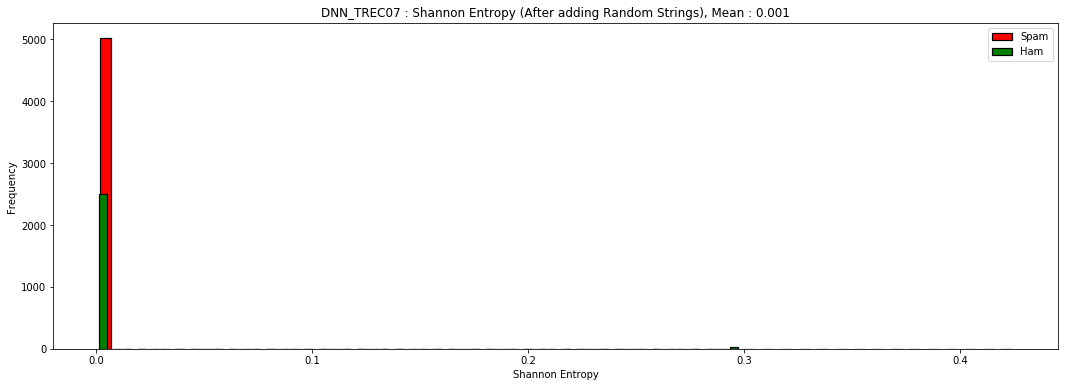

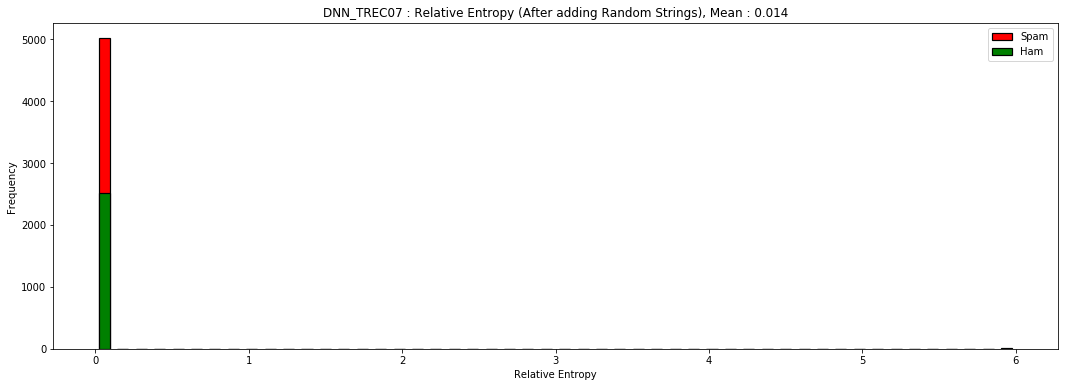

In [49]:
visualise_entropies(dataset, test_x_with_random_strings_dense, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
DNN_TREC07
********************************************************************************
Log Loss :  0.07785330064705404
ROC AUC :  0.9972135249643771
Accuracy :  0.9977459559798462
Classification Report : 
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2522
         1.0       1.00      1.00      1.00      5020

   micro avg       1.00      1.00      1.00      7542
   macro avg       1.00      1.00      1.00      7542
weighted avg       1.00      1.00      1.00      7542



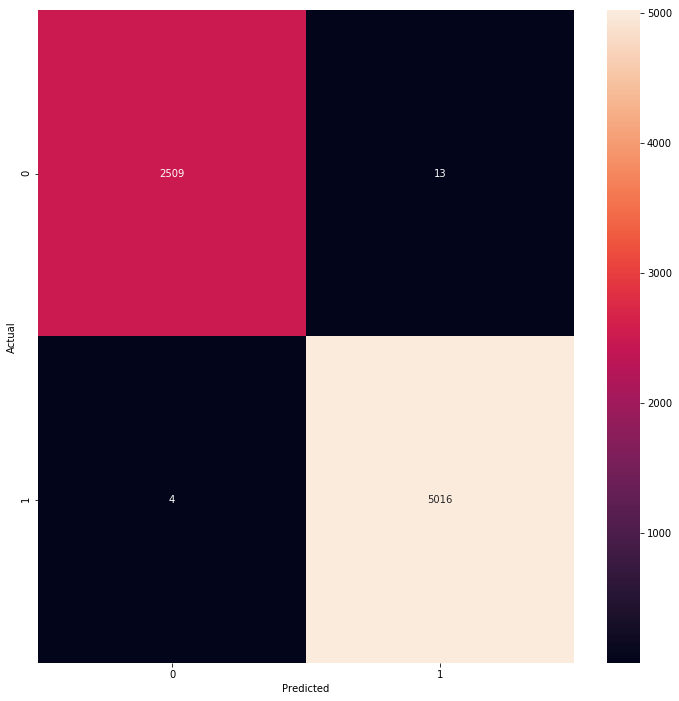

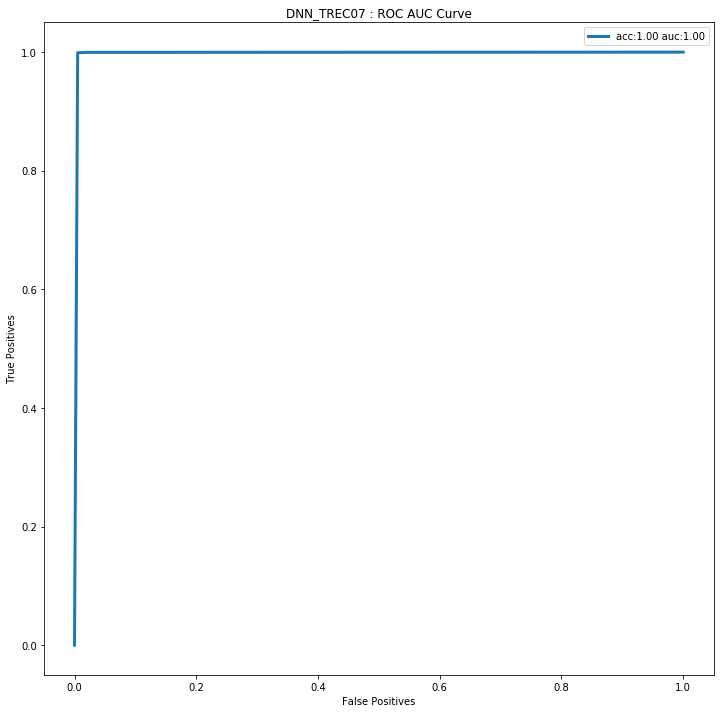

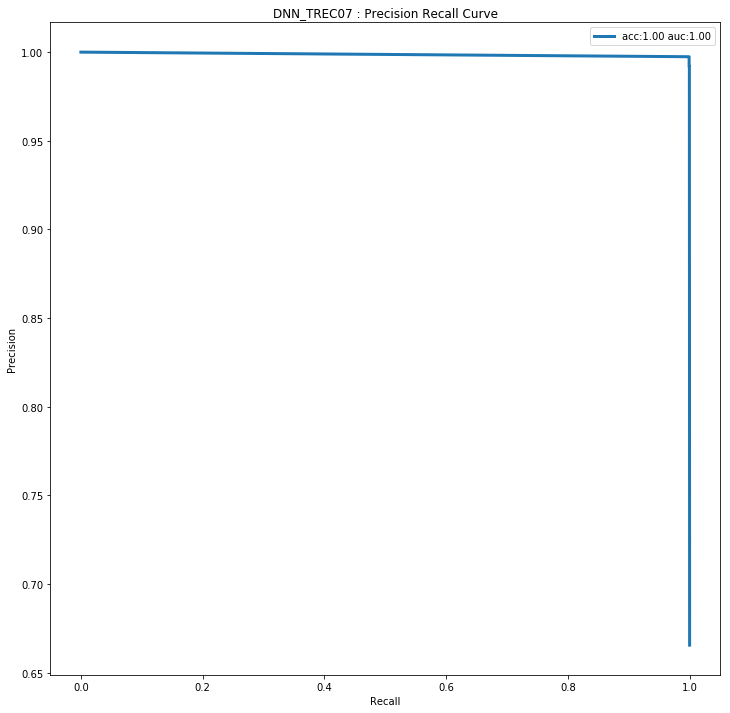

In [50]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_dense, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [51]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
test_x_with_random_strings_dense = tok.texts_to_matrix(test_x_with_random_strings,mode='count')

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
DNN_TREC07
********************************************************************************
Mean Shannon Entropy :  0.04037152
Mean Relative Entropy :  1.9480422281127125
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
47     0.676     0.895     1.0       0       0.591       0.409
52     0.676     0.895     1.0       0       0.591       0.409
80     0.676     0.895     1.0       0       0.591       0.409
86     0.689     0.783     1.0       0       0.543       0.457
130    0.689     0.783     1.0       0       0.543       0.457
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7537      0.0       6.0     0.0       1         0.0         1.0
7538      0.0       6.0     0.0       1         0.0         1.0
7539      0.0       6.0     0.0       1         0.0         1.0
7540      0.0       6.0     0.0       1         0.0         1.0
7541      0.0       6.0     0.

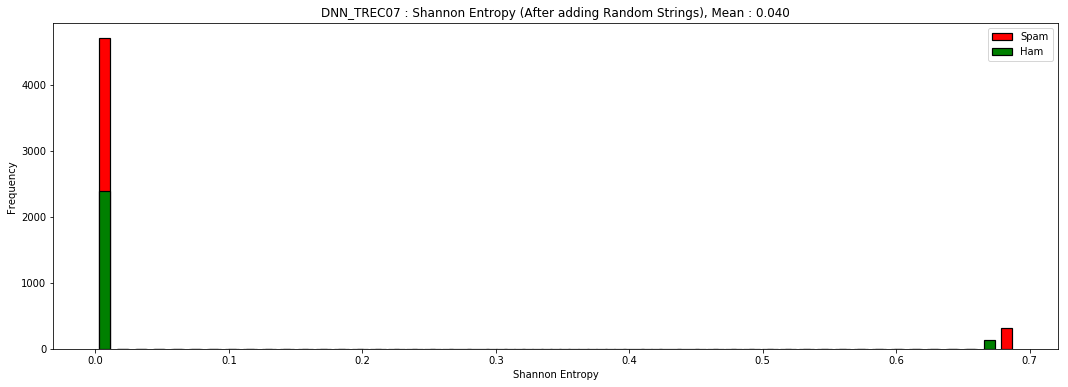

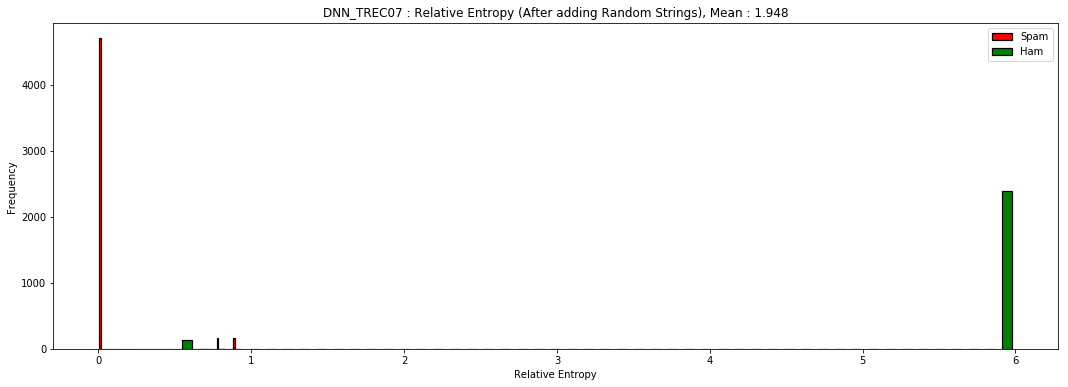

In [52]:
visualise_entropies(dataset, test_x_with_random_strings_dense, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
DNN_TREC07
********************************************************************************
Log Loss :  12.415345563942367
ROC AUC :  0.47643549513287053
Accuracy :  0.6405462741978255
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.29      0.05      0.09      2522
         1.0       0.66      0.94      0.78      5020

   micro avg       0.64      0.64      0.64      7542
   macro avg       0.48      0.49      0.43      7542
weighted avg       0.54      0.64      0.55      7542



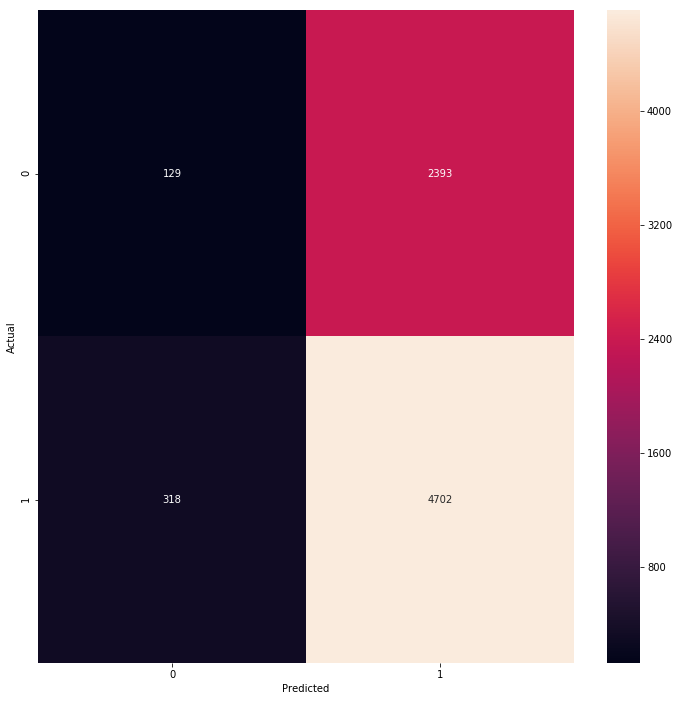

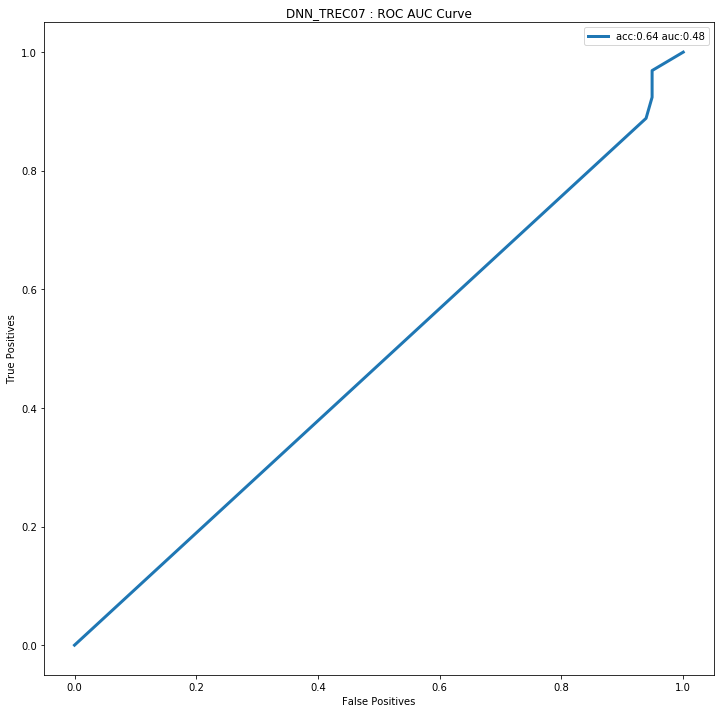

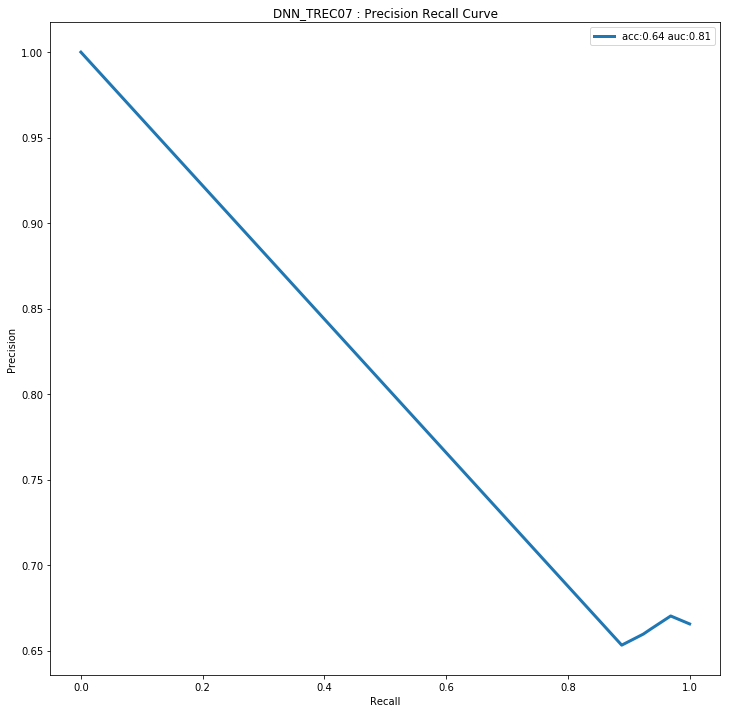

In [53]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_dense, y_test)

## 3. Embeddings with CNNs
### Initial Data Cleaning

In [54]:
grids = {}
max_len = 300
cnn_train_seq = tok.texts_to_sequences(train_x_cleaned)
cnn_test_seq = tok.texts_to_sequences(test_x_cleaned)
#print(cnn_texts_seq[0])
train_x_cnn = sequence.pad_sequences(cnn_train_seq,maxlen=max_len)
test_x_cnn = sequence.pad_sequences(cnn_test_seq,maxlen=max_len)
#print(train_x_cnn[0])
print(train_x_cnn.shape)

(30167, 300)


## CNN Version 1
### Training Model

In [55]:
cnn_v1 = get_cnn_model_v1(max_len)
cnn_v1.fit(train_x_cnn,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['CNN_V1_'+dataset] = copy.deepcopy(cnn_v1)

gc.enable(); gc.collect();

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 24133 samples, validate on 6034 samples
Epoch 1/10
24133/24133 [==============================] - 6s 232us/step - loss: 0.0629 - acc: 0.9814 - val_loss: 0.1046 - val_acc: 0.9877
Epoch 2/10
24133/24133 [==============================] - 5s 201us/step - loss: 0.0189 - acc: 0.9978 - val_loss: 0.0992 - val_acc: 0.9887
Epoch 3/10
24133/24133 [==============================] - 5s 201us/step - loss: 0.0155 - acc: 0.9981 - val_loss: 0.0376 - val_acc: 0.9960
Epoch 4/10
24133/24133 [==============================] - 5s 199us/step - loss: 0.4929 - acc: 0.9682 - val_loss: 4.2282 - val_acc: 0.7340
Epoch 5/10
24133/24133 [==============================] - 5s 199us/step - loss: 0.7544 - acc: 0.9519 - val_loss: 4.2380 - val_acc: 0.7314
Epoch 6/10
24133/24133 [==============================] - 5s 197us/step - loss: 0.7642 - acc: 0.9515 - val_loss: 4.2705 - val_acc: 0.7295
Epoch 7/10
24133/24133 [=====================

## Visualise Shannon and Relative entropies for various models

********************************************************************************
CNN_V1_TREC07
********************************************************************************
Mean Shannon Entropy :  0.0055284705
Mean Relative Entropy :  0.5735307881503234
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
193    0.034     5.204     1.0       0       0.995       0.005
238    0.655     1.015     1.0       0       0.638       0.362
396    0.000     6.000     1.0       0       1.000       0.000
399    0.057     4.575     1.0       0       0.990       0.010
566    0.000     6.000     1.0       0       1.000       0.000
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7516      0.0       6.0     0.0       1         0.0         1.0
7523      0.0       6.0     0.0       1         0.0         1.0
7524      0.0       6.0     0.0       1         0.0         1.0
7534      0.0       6.0     0.0       1         0.0         1.0
7538      0.0       6.0  

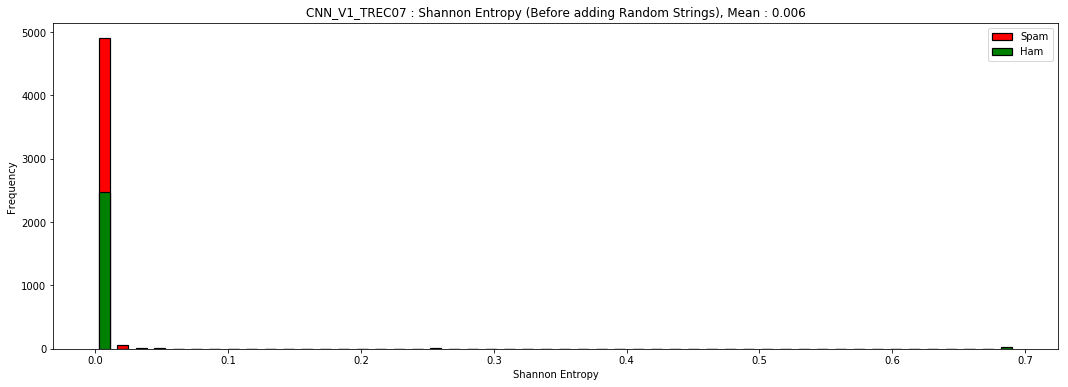

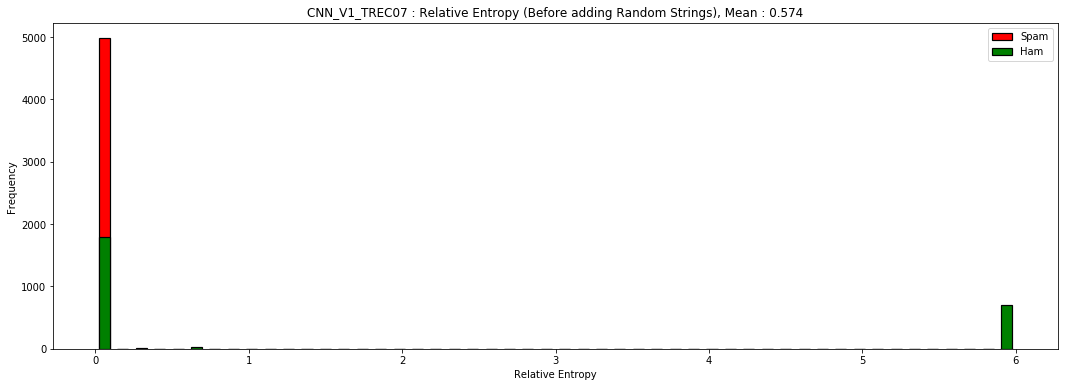

In [56]:
visualise_entropies(dataset, test_x_cnn, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
CNN_V1_TREC07
********************************************************************************
Log Loss :  3.3156496725178095
ROC AUC :  0.7915840997627255
Accuracy :  0.9040042429063909
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83      2522
         1.0       0.88      0.99      0.93      5020

   micro avg       0.90      0.90      0.90      7542
   macro avg       0.93      0.86      0.88      7542
weighted avg       0.91      0.90      0.90      7542



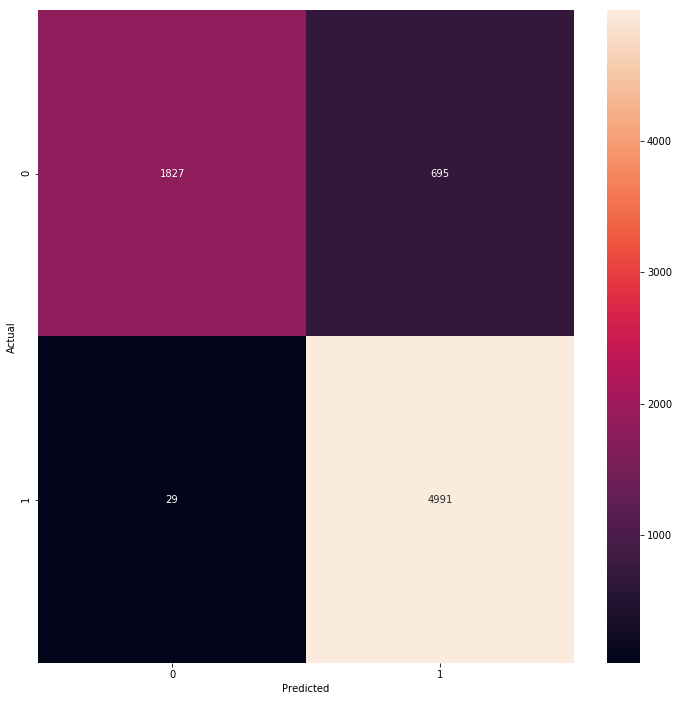

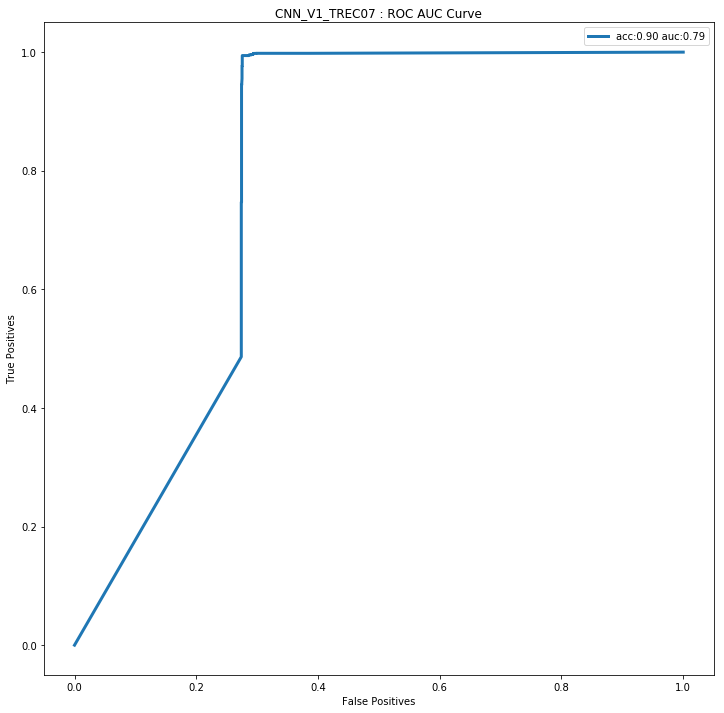

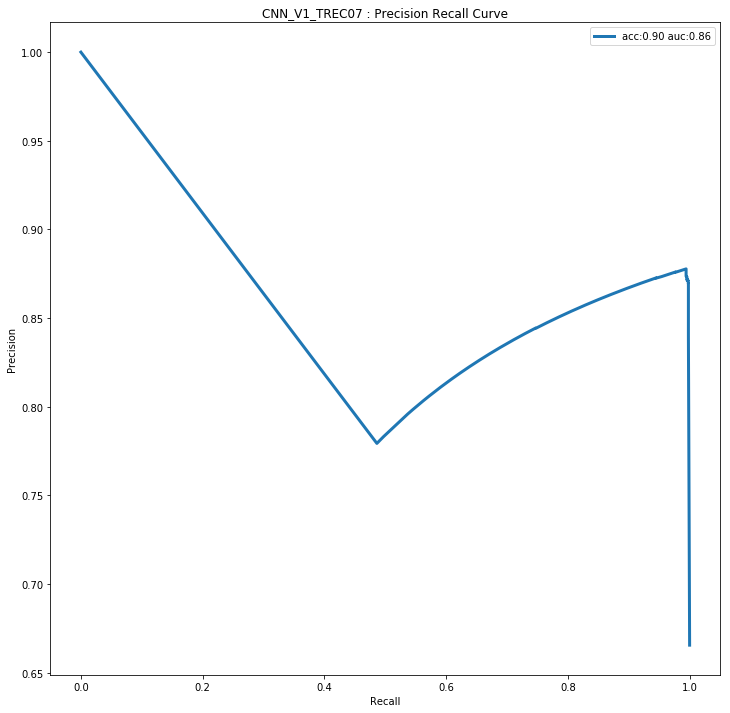

In [57]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cnn, y_test)

## Adding Meaningful Strings to Test Data

In [58]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V1_TREC07
********************************************************************************
Mean Shannon Entropy :  0.006217242
Mean Relative Entropy :  0.5739894483559782
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
193    0.034     5.210     1.0       0       0.995       0.005
238    0.654     1.017     1.0       0       0.638       0.362
396    0.000     6.000     1.0       0       1.000       0.000
399    0.057     4.579     1.0       0       0.990       0.010
566    0.000     6.000     1.0       0       1.000       0.000
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7516      0.0       6.0     0.0       1         0.0         1.0
7523      0.0       6.0     0.0       1         0.0         1.0
7524      0.0       6.0     0.0       1         0.0         1.0
7534      0.0       6.0     0.0       1         0.0         1.0
7538      0.0       6.0   

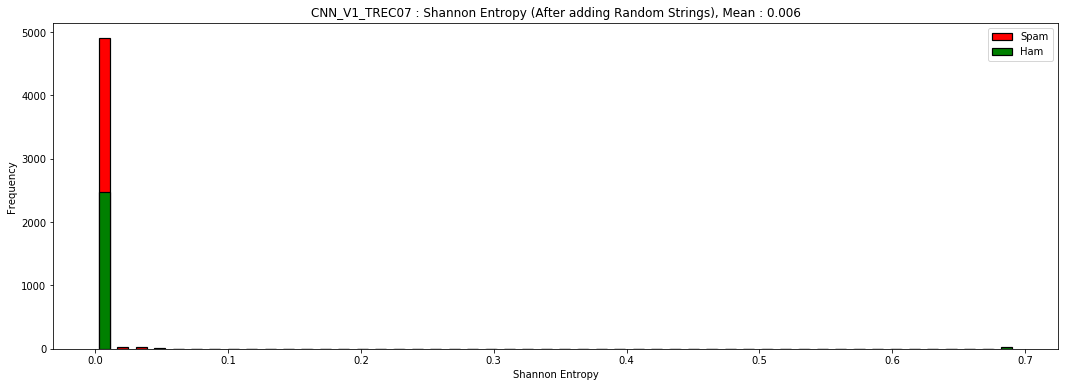

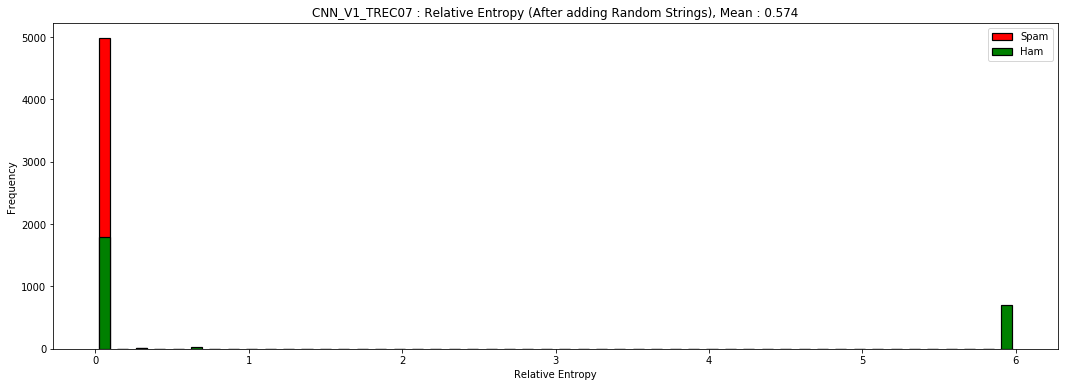

In [59]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V1_TREC07
********************************************************************************
Log Loss :  3.3202291973646556
ROC AUC :  0.7918000875167056
Accuracy :  0.903871652081676
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83      2522
         1.0       0.88      0.99      0.93      5020

   micro avg       0.90      0.90      0.90      7542
   macro avg       0.93      0.86      0.88      7542
weighted avg       0.91      0.90      0.90      7542



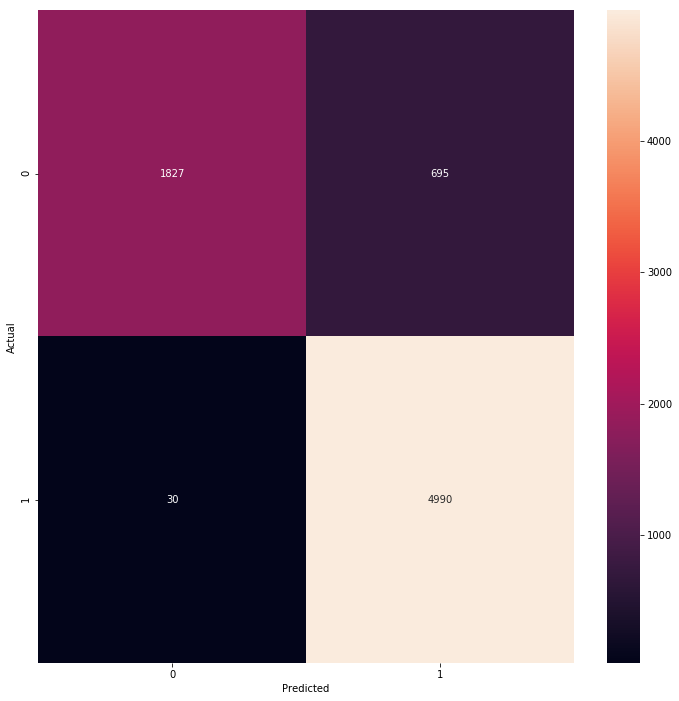

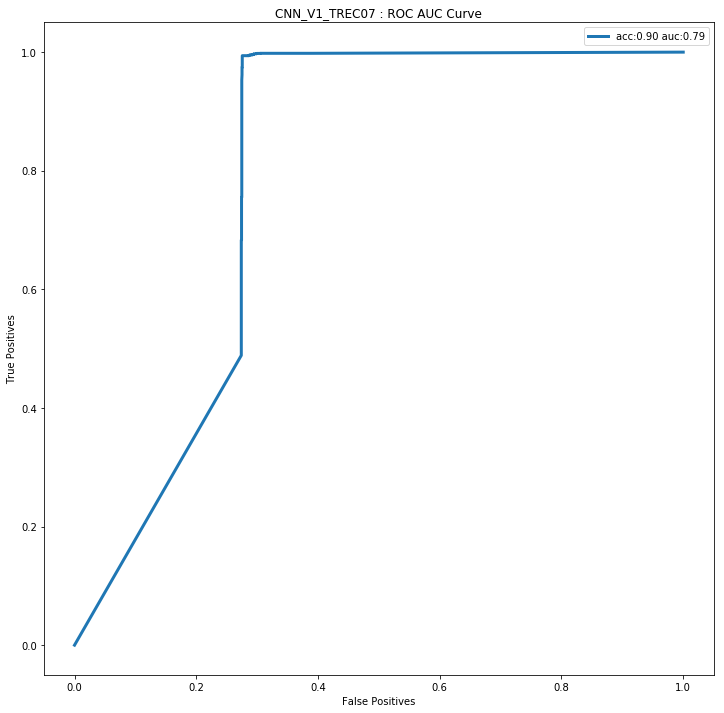

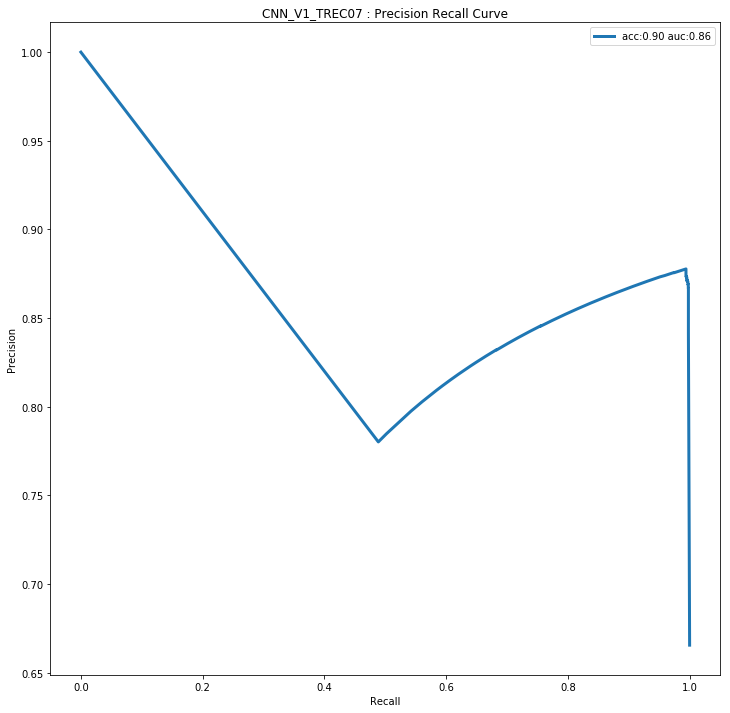

In [60]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [61]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V1_TREC07
********************************************************************************
Mean Shannon Entropy :  0.38217
Mean Relative Entropy :  0.7840656896117527
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
29    0.677     0.889     1.0       0       0.589       0.411
30    0.255     2.650     1.0       0       0.929       0.071
47    0.000     6.000     1.0       0       1.000       0.000
51    0.677     0.889     1.0       0       0.589       0.411
52    0.000     6.000     1.0       0       1.000       0.000
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7536    0.496     1.624     0.0       1       0.197       0.803
7537    0.009     6.000     0.0       1       0.001       0.999
7538    0.693     0.700     0.0       1       0.496       0.504
7540    0.496     1.624     0.0       1       0.197       0.803
7541    0.009     6.000     0.0     

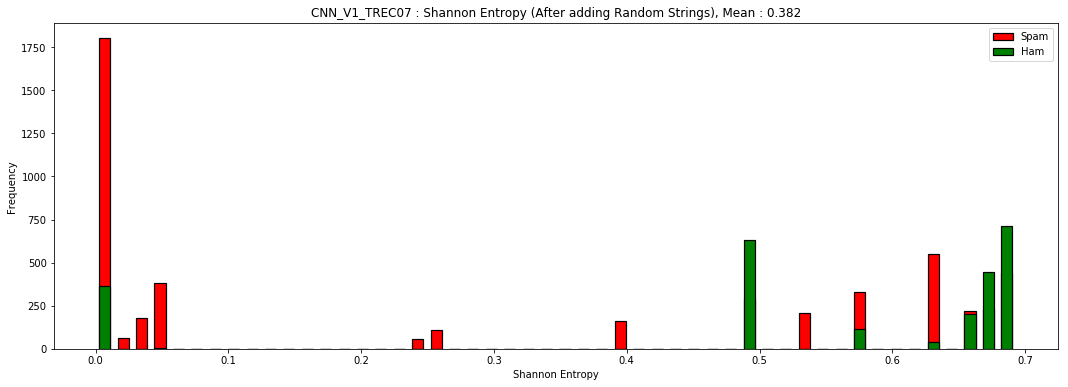

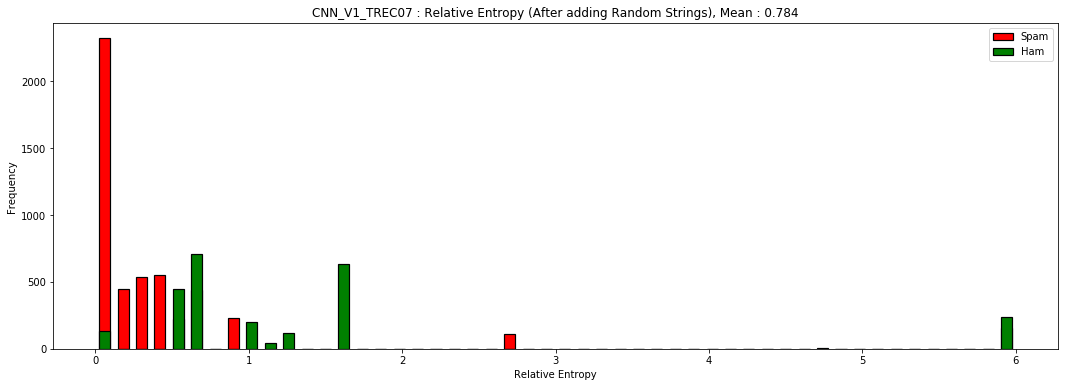

In [62]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V1_TREC07
********************************************************************************
Log Loss :  11.201724088908868
ROC AUC :  0.7176553895441233
Accuracy :  0.6756828427472819
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.54      0.23      0.32      2522
         1.0       0.70      0.90      0.79      5020

   micro avg       0.68      0.68      0.68      7542
   macro avg       0.62      0.56      0.55      7542
weighted avg       0.64      0.68      0.63      7542



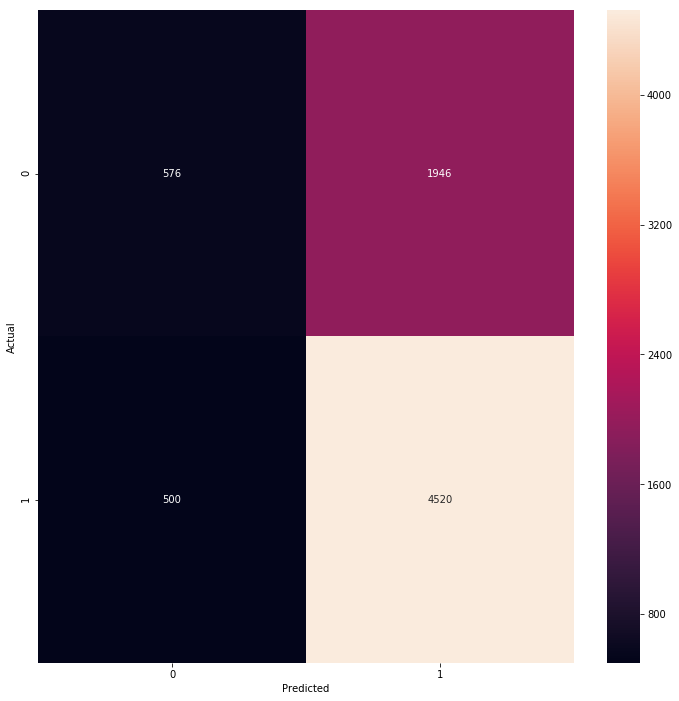

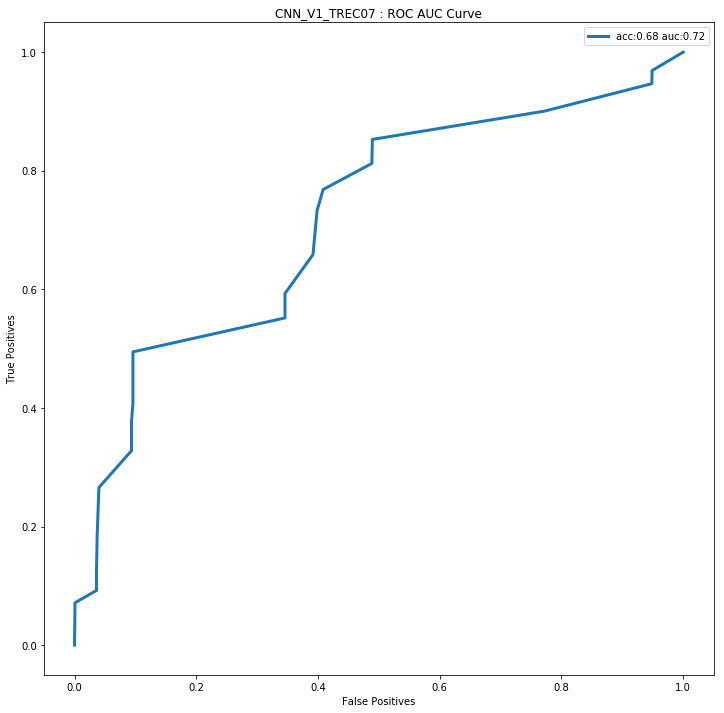

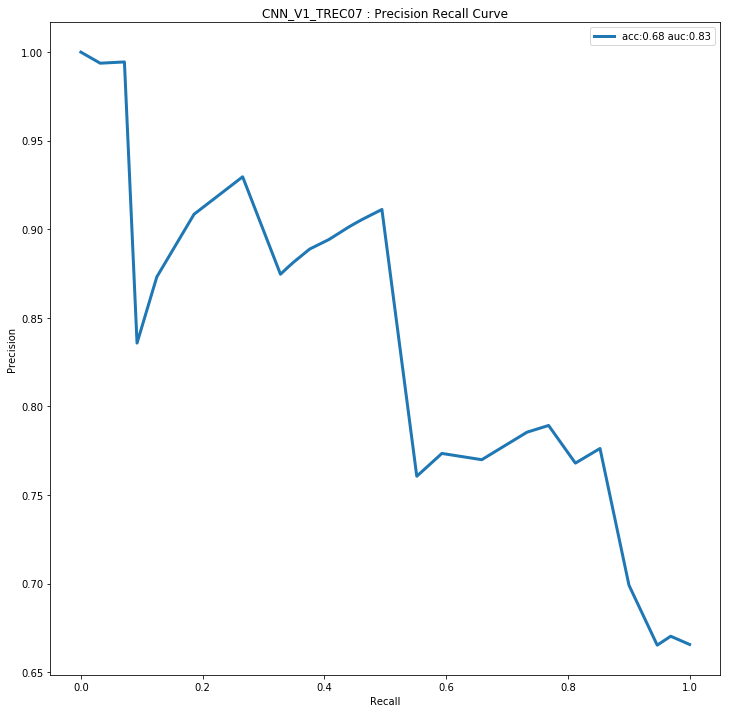

In [63]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## CNN Version 2
### Training Model

In [64]:
grids = {}
cnn_v2 = get_cnn_model_v2(max_len)
cnn_v2.fit(train_x_cnn,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['CNN_V2_'+dataset] = copy.deepcopy(cnn_v2)

gc.enable(); gc.collect();

Train on 24133 samples, validate on 6034 samples
Epoch 1/10
24133/24133 [==============================] - 6s 251us/step - loss: 0.1310 - acc: 0.9760 - val_loss: 0.4479 - val_acc: 0.9674
Epoch 2/10
24133/24133 [==============================] - 5s 215us/step - loss: 0.0808 - acc: 0.9926 - val_loss: 0.4264 - val_acc: 0.9695
Epoch 3/10
24133/24133 [==============================] - 5s 215us/step - loss: 0.0648 - acc: 0.9946 - val_loss: 0.4324 - val_acc: 0.9713
Epoch 4/10
24133/24133 [==============================] - 5s 216us/step - loss: 0.0658 - acc: 0.9947 - val_loss: 0.4379 - val_acc: 0.9677
Epoch 5/10
24133/24133 [==============================] - 5s 215us/step - loss: 0.0693 - acc: 0.9941 - val_loss: 0.4453 - val_acc: 0.9683
Epoch 6/10
24133/24133 [==============================] - 5s 215us/step - loss: 0.1142 - acc: 0.9917 - val_loss: 1.0525 - val_acc: 0.9314
Epoch 7/10
24133/24133 [==============================] - 5s 214us/step - loss: 0.1663 - acc: 0.9886 - val_loss: 1.0614 - v

## Visualise Shannon and Relative entropies for various models

********************************************************************************
CNN_V2_TREC07
********************************************************************************
Mean Shannon Entropy :  0.006029331
Mean Relative Entropy :  0.161707893903438
Head 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
193     0.477     1.693     1.0       0       0.816       0.184
399     0.314     2.355     1.0       0       0.905       0.095
1057    0.000     6.000     1.0       0       1.000       0.000
1260    0.187     3.074     1.0       0       0.954       0.046
1980    0.000     6.000     1.0       0       1.000       0.000
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7508    0.156     3.317     0.0       1       0.036       0.964
7529    0.183     3.107     0.0       1       0.045       0.955
7533    0.000     6.000     0.0       1       0.000       1.000
7537    0.000     6.000     0.0       1       0.000       1.000
7541    0.000     6.0

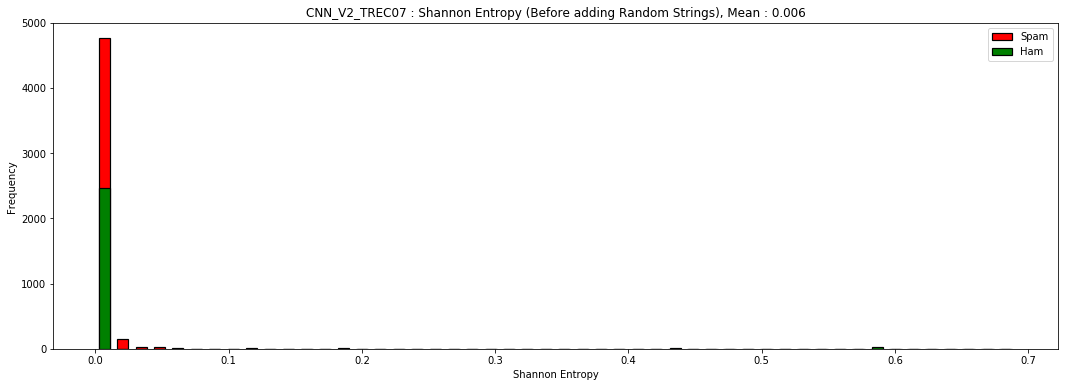

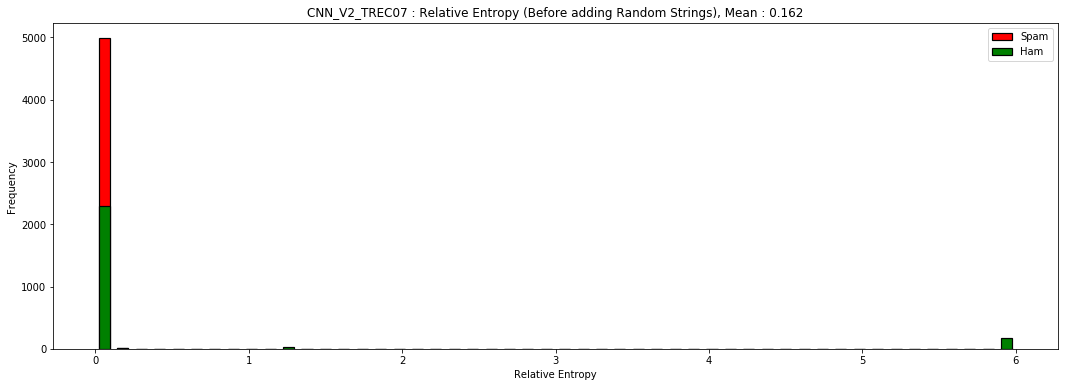

In [65]:
visualise_entropies(dataset, test_x_cnn, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
CNN_V2_TREC07
********************************************************************************
Log Loss :  1.0945291265226362
ROC AUC :  0.9475690813273473
Accuracy :  0.9683107928931318
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95      2522
         1.0       0.96      1.00      0.98      5020

   micro avg       0.97      0.97      0.97      7542
   macro avg       0.97      0.96      0.96      7542
weighted avg       0.97      0.97      0.97      7542



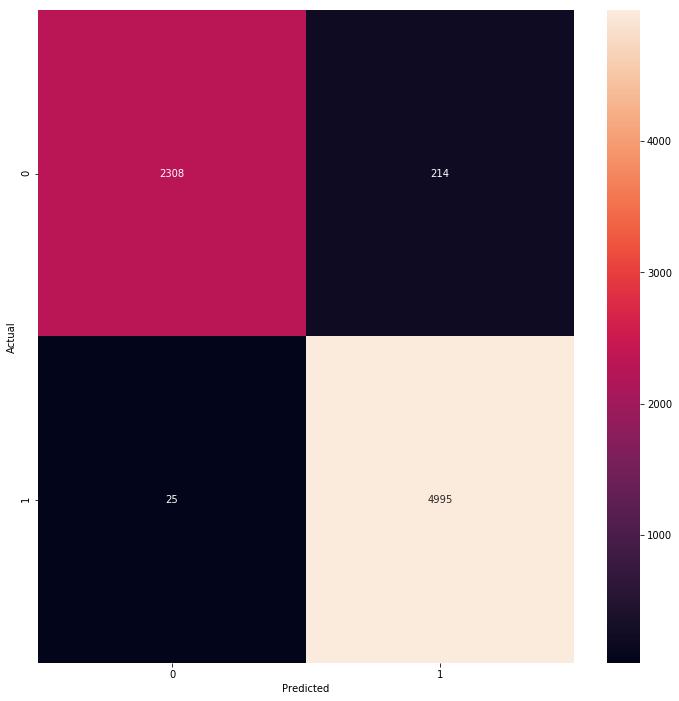

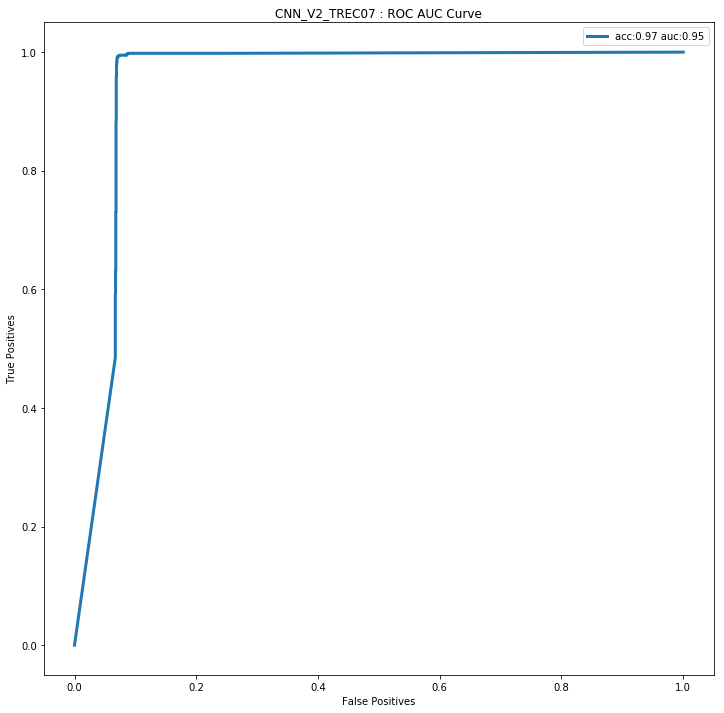

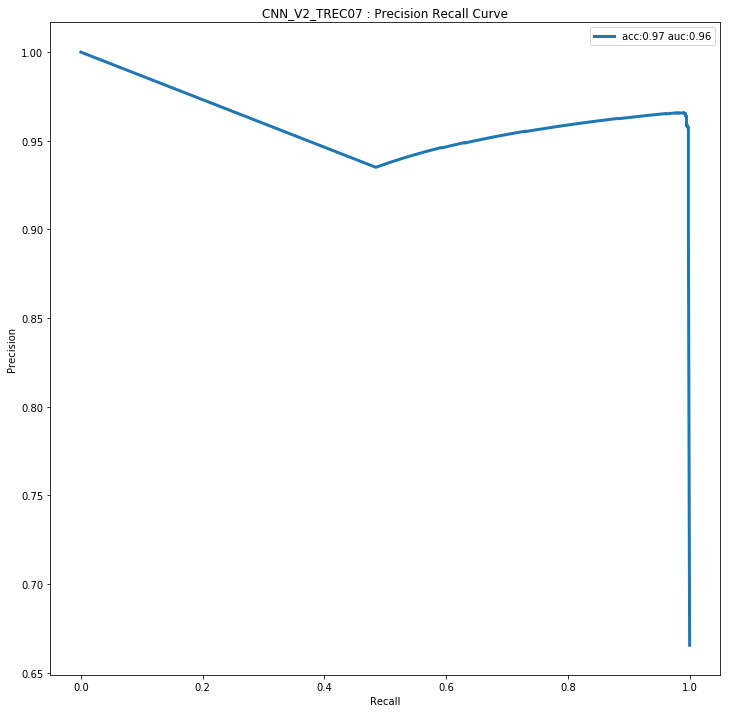

In [66]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cnn, y_test)

## Adding Meaningful Strings to Test Data

In [67]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V2_TREC07
********************************************************************************
Mean Shannon Entropy :  0.0052902517
Mean Relative Entropy :  0.16845192259522312
Head 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1057    0.000     6.000     1.0       0        1.00        0.00
1260    0.692     0.734     1.0       0        0.52        0.48
1980    0.000     6.000     1.0       0        1.00        0.00
2513    0.000     6.000     1.0       0        1.00        0.00
2554    0.000     6.000     1.0       0        1.00        0.00
Tail 5 : 
        Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7508  5.645e-02     4.595     0.0       1   1.010e-02        0.99
7529  4.693e-05     6.000     0.0       1   3.457e-06        1.00
7533  0.000e+00     6.000     0.0       1   0.000e+00        1.00
7537  0.000e+00     6.000     0.0       1   0.000e+00        1.00
7541  0.

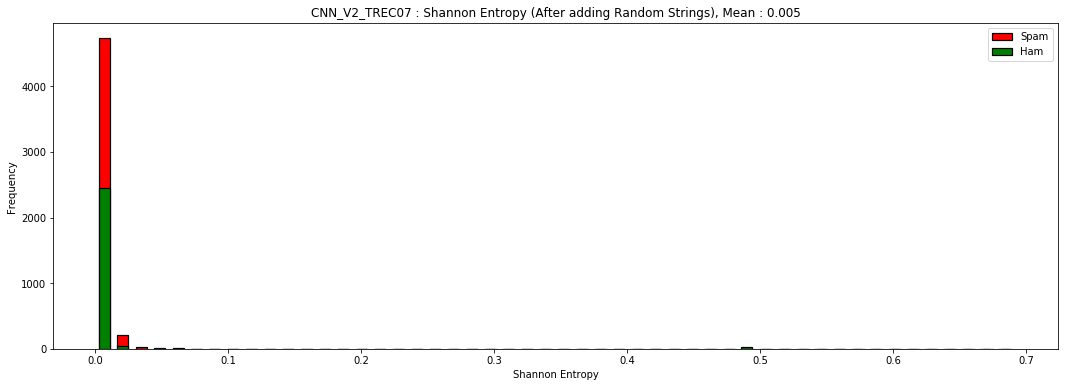

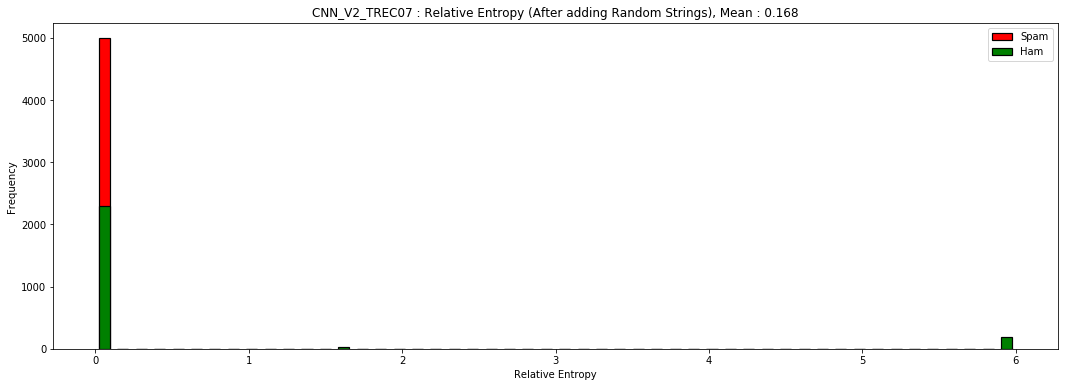

In [68]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V2_TREC07
********************************************************************************
Log Loss :  1.080791612174926
ROC AUC :  0.9456230984073224
Accuracy :  0.9687085653672766
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      2522
         1.0       0.96      1.00      0.98      5020

   micro avg       0.97      0.97      0.97      7542
   macro avg       0.98      0.95      0.96      7542
weighted avg       0.97      0.97      0.97      7542



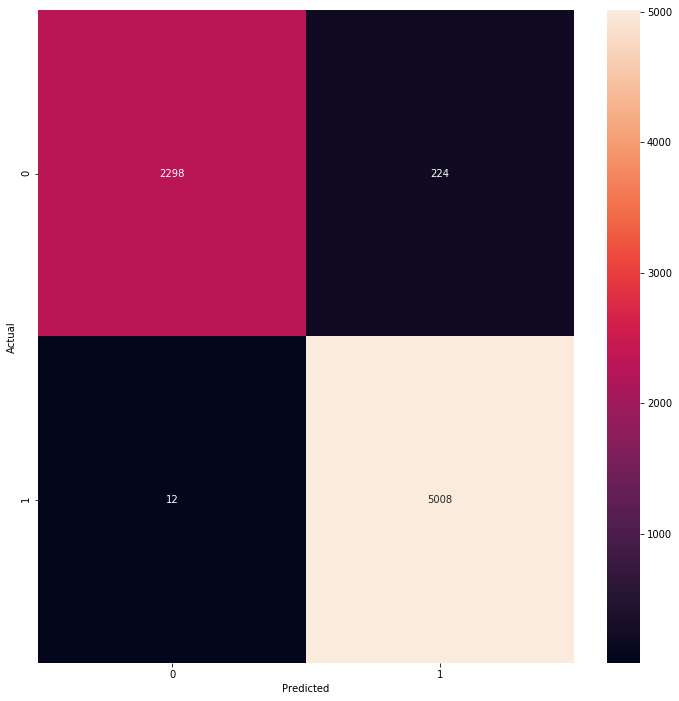

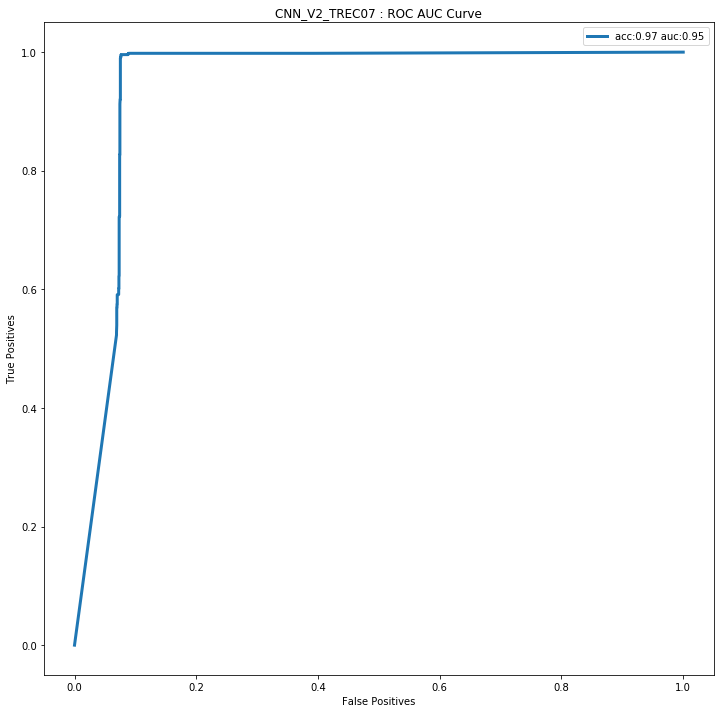

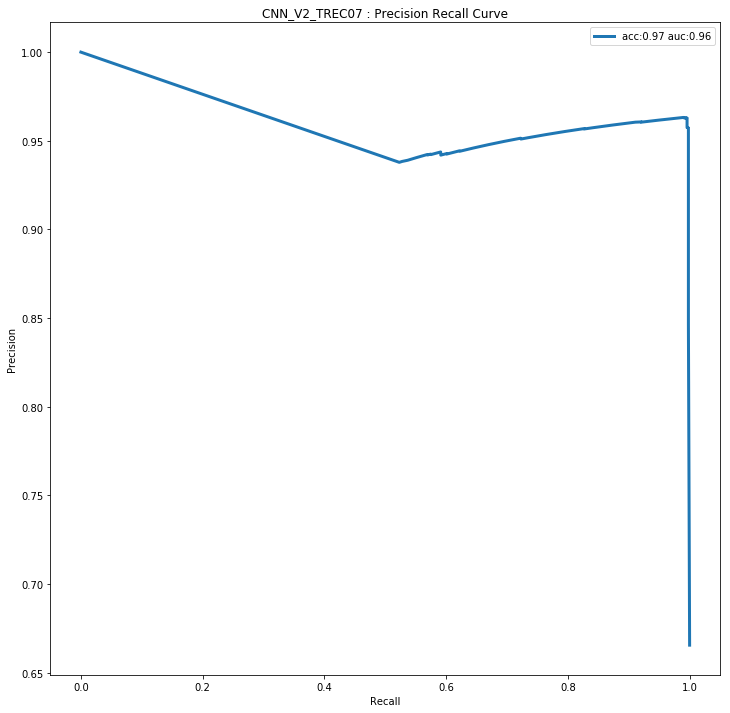

In [69]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [70]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V2_TREC07
********************************************************************************
Mean Shannon Entropy :  0.3572551
Mean Relative Entropy :  0.7758907536554932
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
30     0.339     2.241     1.0       0       0.894       0.106
115    0.339     2.241     1.0       0       0.894       0.106
149    0.339     2.241     1.0       0       0.894       0.106
158    0.339     2.241     1.0       0       0.894       0.106
166    0.339     2.241     1.0       0       0.894       0.106
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
7537    0.549     1.435     0.0       1       0.238       0.762
7538    0.584     1.306     0.0       1       0.271       0.729
7539    0.573     1.348     0.0       1       0.260       0.740
7540    0.319     2.332     0.0       1       0.097       0.903
7541    0.549     1.435     

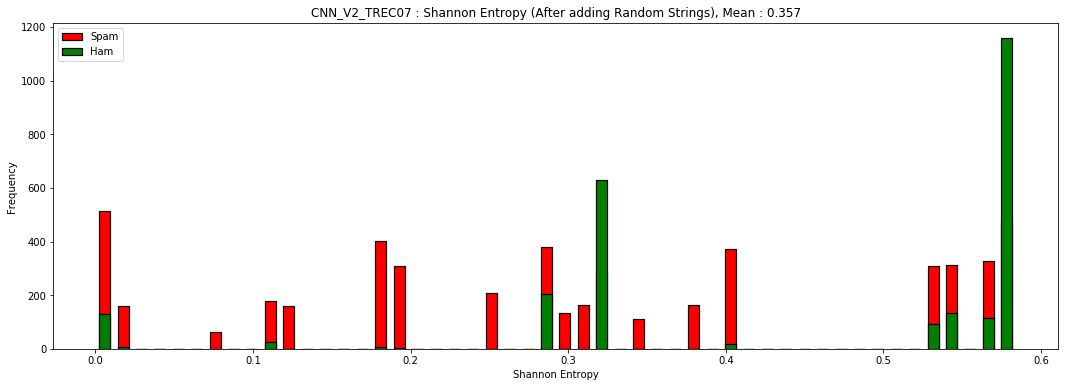

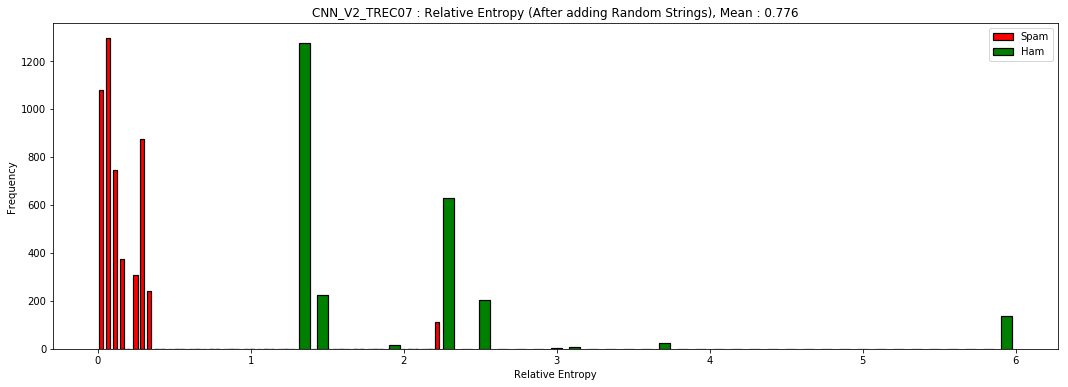

In [71]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V2_TREC07
********************************************************************************
Log Loss :  12.053576671509738
ROC AUC :  0.7231574889972229
Accuracy :  0.651020949350305
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.01      0.00      0.00      2522
         1.0       0.66      0.98      0.79      5020

   micro avg       0.65      0.65      0.65      7542
   macro avg       0.33      0.49      0.39      7542
weighted avg       0.44      0.65      0.53      7542



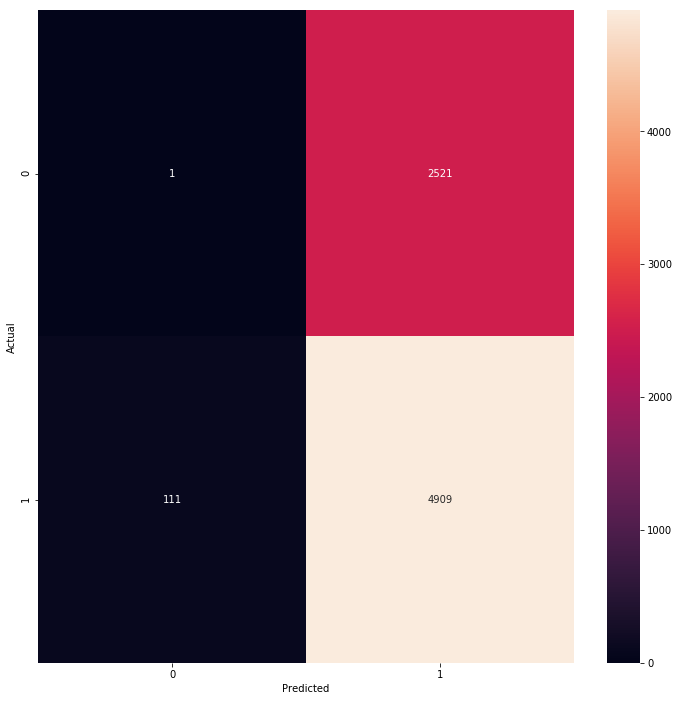

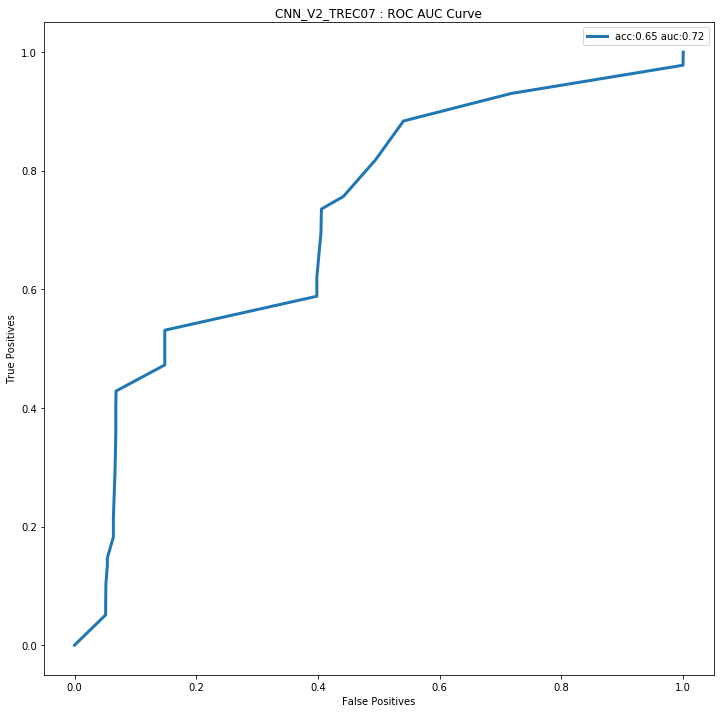

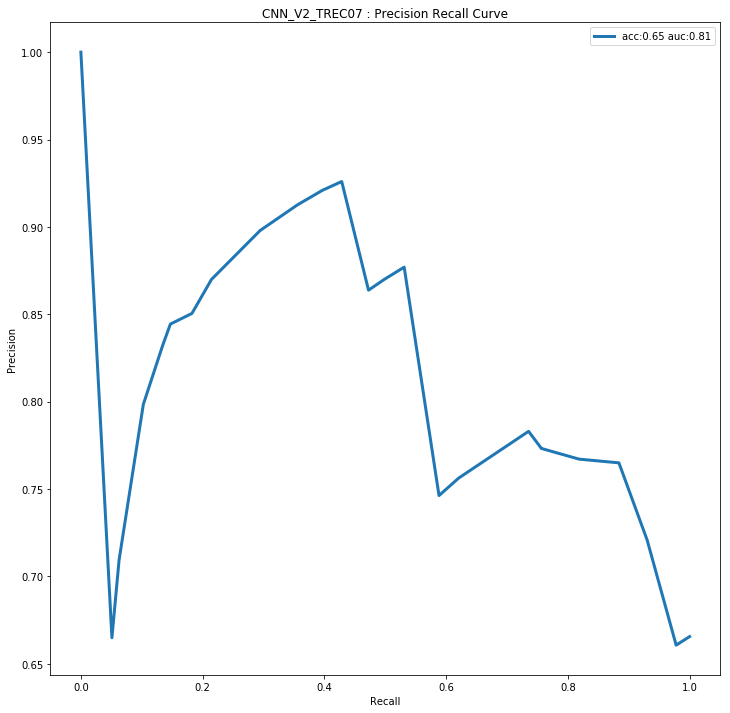

In [72]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)